### Fama-French model

------------------------------------------------------------------------------------------------------------------------------------
 Fama-French model: 시장(MKT), 크기(SMB), 가치(HML), 수익성(RMW), 투자(5-factor의 CMA) 등 여러 요인을 기반으로 주식 포트폴리오의 수익률을 설명하는 모델 
 개요: Fama-French 5-factor 모델을 적용하여, 한국 상장기업의 주식 수익률을 시장, 규모, 가치, 수익성, 투자 요인으로 분석하고 파이썬으로 구현하고자 함

In [30]:
import sys
print(sys.version)

3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]


0-1.터미널 설치(pykrx, opendartreader)

In [1]:
pip install pykrx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install OpenDartReader

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


0-2.파이썬 다운그레이드(3.13.2->3.10.0)

In [22]:
import sys
print(sys.version)

3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]


In [1]:
import sys
print(sys.version)

3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [20]:
import dart_fss as dart

In [11]:
pip uninstall OpenDartReader
pip install OpenDartReader --upgrade

^C



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1.한국시장에 상장된 기업 전체 데이터(월말 종가, 월말 시가총액, 종목명, 업종명)가져오기

In [ ]:
2.데이터 전처리 : 9만 이상 종목코드 보유하고 있는 기업 삭제, pbr 0인 종목 제거

3-1. 재무제표 데이터 수집(영업이익/자기자본, 자본증가율)

In [12]:
import pandas as pd
import numpy as np
import time
import pickle
import os
from tqdm import tqdm
import OpenDartReader

API_KEY = '	1dd1baa5c8046bbe59e177f3de06486b668cf678' # 058bf06eae89bcc18cc1d168b513b3e8f1edaea7 
# 8a0be11993744250453be56e4cfeb903eec9e608
dart = OpenDartReader(API_KEY)
input_path = "all_sector_monthly_return_clean.csv"
output_path = "all_sector_monthly_op.csv"
cache_path = "dart_data_cache.pkl"

df = pd.read_csv(input_path, encoding='cp949')
df['월말일자'] = pd.to_datetime(df['월말일자'])

def get_quarter(month):
    if month in [1,2,3]: return '11013'
    elif month in [4,5,6]: return '11012'
    elif month in [7,8,9]: return '11014'
    else: return '11011'

df['연도'] = df['월말일자'].dt.year
df['분기코드'] = df['월말일자'].dt.month.map(get_quarter)

key_cols = ['종목코드', '연도', '분기코드']
unique_keys = df[key_cols].drop_duplicates().reset_index(drop=True)

# 1. 캐시 불러오기
if os.path.exists(cache_path):
    with open(cache_path, 'rb') as f:
        dart_data = pickle.load(f)
    print(f"기존 캐시 불러옴: {len(dart_data)}개")
else:
    dart_data = {}

# 2. 중복된 키는 건너뜀
n_save = 0
for i, row in tqdm(unique_keys.iterrows(), total=unique_keys.shape[0], desc="DART 분기별 크롤링"):
    code = str(row['종목코드']).zfill(6)
    year = str(row['연도'])
    reprt_code = row['분기코드']
    key = (code, year, reprt_code)
    if key in dart_data:
        continue  # 이미 저장된 데이터는 skip
    try:
        fs = dart.finstate(code, bsns_year=year, reprt_code=reprt_code)
        if fs is None or fs.empty:
            dart_data[key] = (np.nan, np.nan, np.nan, np.nan)
            continue
        def safe_float(x):
            try:
                return float(str(x).replace(',', '')) if x not in [None, '', '-', 'nan', 'NaN', np.nan] else np.nan
            except:
                return np.nan
        op_profit = fs.loc[fs['account_nm'].str.contains('영업이익'), 'thstrm_amount']
        equity = fs.loc[fs['account_nm'].str.contains('자본총계'), 'thstrm_amount']
        total_asset = fs.loc[fs['account_nm'].str.contains('자산총계'), 'thstrm_amount']
        prev_asset = fs.loc[fs['account_nm'].str.contains('자산총계'), 'frmtrm_amount']
        op_profit = safe_float(op_profit.values[0]) if len(op_profit) else np.nan
        equity = safe_float(equity.values[0]) if len(equity) else np.nan
        total_asset = safe_float(total_asset.values[0]) if len(total_asset) else np.nan
        prev_asset = safe_float(prev_asset.values[0]) if len(prev_asset) else np.nan
        dart_data[key] = (op_profit, equity, total_asset, prev_asset)
    except Exception as e:
        print(f"Error at {code}, {year}, {reprt_code}: {e}")
        dart_data[key] = (np.nan, np.nan, np.nan, np.nan)
    time.sleep(0.3)
    n_save += 1
    # 500건마다 저장
    if n_save % 500 == 0:
        with open(cache_path, 'wb') as f:
            pickle.dump(dart_data, f)
        print(f"{n_save}건 저장함 (누적 {len(dart_data)})")

# 종료 후도 반드시 저장!
with open(cache_path, 'wb') as f:
    pickle.dump(dart_data, f)
print(f"최종 {len(dart_data)}건 저장함")

# 3. 원본 df에 파생변수 입력
df['영업이익/자기자본'] = np.nan
df['자산증가율'] = np.nan

for i in tqdm(df.index, desc="월별 값 채우기/계산"):
    code = str(df.loc[i, '종목코드']).zfill(6)
    year = str(df.loc[i, '연도'])
    reprt_code = df.loc[i, '분기코드']
    op_profit, equity, total_asset, prev_asset = dart_data.get((code, year, reprt_code), (np.nan, np.nan, np.nan, np.nan))
    df.loc[i, '영업이익/자기자본'] = (
        op_profit / equity if (pd.notnull(op_profit) and pd.notnull(equity) and equity != 0) else np.nan
    )
    df.loc[i, '자산증가율'] = (
        (total_asset - prev_asset) / prev_asset if (pd.notnull(total_asset) and pd.notnull(prev_asset) and prev_asset != 0) else np.nan
    )

df.to_csv(output_path, index=False, encoding='cp949')

기존 캐시 불러옴: 30050개


DART 분기별 크롤링:  41%|█████████████████████▊                               | 28891/70010 [00:02<00:03, 13199.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048430, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048430, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  43%|███████████████████████▋                               | 30093/70010 [00:22<03:20, 198.74it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048470, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048470, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  43%|████████████████████████                                | 30134/70010 [00:40<08:41, 76.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048530, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048530, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  43%|████████████████████████▏                               | 30178/70010 [01:00<20:33, 32.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048550, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048550, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  43%|████████████████████████▏                               | 30216/70010 [01:20<42:04, 15.76it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048770, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048770, 2025, 11014: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048830, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048830, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  43%|███████████████████████▎                              | 30262/70010 [01:40<1:16:33,  8.65it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048870, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  43%|███████████████████████▎                              | 30304/70010 [02:00<2:06:44,  5.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048910, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 048910, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  43%|███████████████████████▍                              | 30350/70010 [02:20<2:57:32,  3.72it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 049070, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 049070, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  43%|███████████████████████▊                               | 30371/70010 [02:31<03:17, 200.81it/s]


KeyboardInterrupt: 

In [11]:
import pandas as pd

# 예시: DataFrame이 df라고 가정
cols = [
    '날짜', '월말일자', '월말종가', '월말시가총액', '종목코드', '종목명', '업종명', '1/pbr', '월별수익률', '영업이익/자기자본', '자산증가율'
]

# 혹시 df에 없는 컬럼이 있을 경우, 있는 컬럼만 선택
cols_existing = [col for col in cols if col in df.columns]

# 저장
df[cols_existing].to_csv("final_data.csv", index=False, encoding='cp949')  # 한글이면 cp949
print("최종 분석용 데이터 저장 완료! (행 개수:", len(df), ")")

최종 분석용 데이터 저장 완료! (행 개수: 309 )


In [7]:
import pandas as pd

df = pd.read_csv("all_sector_monthly_op.csv", encoding='cp949')
print(df.head())

       날짜        월말일자  월말종가   월말거래량        월말시가총액   PBR  종목코드   종목명     업종명  \
0  17-Jan  2017-01-31  8210   86947  2.290000e+11  1.00    20  동화약품  제약및바이오   
1  17-Feb  2017-02-28  8900  316121  2.490000e+11  1.08    20  동화약품  제약및바이오   
2  17-Mar  2017-03-31  9090  442169  2.540000e+11  1.10    20  동화약품  제약및바이오   
3  17-Apr  2017-04-28  9200   59476  2.570000e+11  1.12    20  동화약품  제약및바이오   
4  17-May  2017-05-31  8990  150658  2.510000e+11  0.99    20  동화약품  제약및바이오   

      1/PBR     월별수익률    연도   분기코드  영업이익/자기자본     자산증가율  
0  1.000000       NaN  2017  11013   0.018385 -0.006512  
1  0.925926  0.084044  2017  11013   0.018385 -0.006512  
2  0.909091  0.021348  2017  11013   0.018385 -0.006512  
3  0.892857  0.012101  2017  11012   0.016714  0.024380  
4  1.010101 -0.022826  2017  11012   0.016714  0.024380  


In [10]:
import pickle
import pandas as pd

# 1. 캐시 파일 불러오기
with open("dart_data_cache.pkl", "rb") as f:
    dart_data = pickle.load(f)

# 2. 딕셔너리를 DataFrame으로 변환
df_cache = pd.DataFrame([
    [k[0], k[1], k[2], v[0], v[1], v[2], v[3]]
    for k, v in dart_data.items()
], columns=['종목코드', '연도', '분기코드', '영업이익', '자기자본', '총자산', '이전총자산'])

# 3. csv로 저장 (원하는 경로/이름으로 수정 가능)
df_cache.to_csv("dart_data.csv", index=False, encoding='cp949')

print("새 CSV로 저장 완료! (행 개수:", len(df_cache), ")")

새 CSV로 저장 완료! (행 개수: 30050 )


In [ ]:
import pandas as pd

# 예시: DataFrame이 df라고 가정
cols = [
    '날짜', '월말일자', '월말종가', '월말시가총액', '종목코드', '종목명', '업종명', '1/pbr', '월별수익률', '영업이익/자기자본', '자산증가율'
]

# 혹시 df에 없는 컬럼이 있을 경우, 있는 컬럼만 선택
cols_existing = [col for col in cols if col in df.columns]

# 저장
df[cols_existing].to_csv("final_analysis_data.csv", index=False, encoding='cp949')  
print("최종 분석용 데이터 저장 완료! (행 개수:", len(df), ")")

3.재무제표 데이터 수집(영업이익/자기자본, 자본증가율) (2)

In [1]:
import pandas as pd
import numpy as np
import time
import pickle
import os
from tqdm import tqdm
import OpenDartReader

API_KEY = '8a0be11993744250453be56e4cfeb903eec9e608' # 
# 8a0be11993744250453be56e4cfeb903eec9e608 # 1dd1baa5c8046bbe59e177f3de06486b668cf678
dart = OpenDartReader(API_KEY)
input_path = "all_sector_monthly_return_clean.csv"
output_path = "all_sector_file.csv"
cache_path = "dart_data_cache.pkl"

df = pd.read_csv(input_path, encoding='cp949')
df['월말일자'] = pd.to_datetime(df['월말일자'])

def get_quarter(month):
    if month in [1,2,3]: return '11013'
    elif month in [4,5,6]: return '11012'
    elif month in [7,8,9]: return '11014'
    else: return '11011'

df['연도'] = df['월말일자'].dt.year
df['분기코드'] = df['월말일자'].dt.month.map(get_quarter)

key_cols = ['종목코드', '연도', '분기코드']
unique_keys = df[key_cols].drop_duplicates().reset_index(drop=True)

# 1. 캐시 불러오기
if os.path.exists(cache_path):
    with open(cache_path, 'rb') as f:
        dart_data = pickle.load(f)
    print(f"기존 캐시 불러옴: {len(dart_data)}개")
else:
    dart_data = {}

# 2. 중복된 키는 건너뜀
n_save = 0
for i, row in tqdm(unique_keys.iterrows(), total=unique_keys.shape[0], desc="DART 분기별 크롤링"):
    code = str(row['종목코드']).zfill(6)
    year = str(row['연도'])
    reprt_code = row['분기코드']
    key = (code, year, reprt_code)
    if key in dart_data:
        continue  # 이미 저장된 데이터는 skip
    try:
        fs = dart.finstate(code, bsns_year=year, reprt_code=reprt_code)
        if fs is None or fs.empty:
            dart_data[key] = (np.nan, np.nan, np.nan, np.nan)
            continue
        def safe_float(x):
            try:
                return float(str(x).replace(',', '')) if x not in [None, '', '-', 'nan', 'NaN', np.nan] else np.nan
            except:
                return np.nan
        op_profit = fs.loc[fs['account_nm'].str.contains('영업이익'), 'thstrm_amount']
        equity = fs.loc[fs['account_nm'].str.contains('자본총계'), 'thstrm_amount']
        total_asset = fs.loc[fs['account_nm'].str.contains('자산총계'), 'thstrm_amount']
        prev_asset = fs.loc[fs['account_nm'].str.contains('자산총계'), 'frmtrm_amount']
        op_profit = safe_float(op_profit.values[0]) if len(op_profit) else np.nan
        equity = safe_float(equity.values[0]) if len(equity) else np.nan
        total_asset = safe_float(total_asset.values[0]) if len(total_asset) else np.nan
        prev_asset = safe_float(prev_asset.values[0]) if len(prev_asset) else np.nan
        dart_data[key] = (op_profit, equity, total_asset, prev_asset)
    except Exception as e:
        print(f"Error at {code}, {year}, {reprt_code}: {e}")
        dart_data[key] = (np.nan, np.nan, np.nan, np.nan)
    time.sleep(0.3)
    n_save += 1
    # 500건마다 저장
    if n_save % 500 == 0:
        with open(cache_path, 'wb') as f:
            pickle.dump(dart_data, f)
        print(f"{n_save}건 저장함 (누적 {len(dart_data)})")

# 종료 후도 반드시 저장!
with open(cache_path, 'wb') as f:
    pickle.dump(dart_data, f)
print(f"최종 {len(dart_data)}건 저장함")

# 3. 원본 df에 파생변수 입력
df['영업이익/자기자본'] = np.nan
df['자산증가율'] = np.nan

for i in tqdm(df.index, desc="월별 값 채우기/계산"):
    code = str(df.loc[i, '종목코드']).zfill(6)
    year = str(df.loc[i, '연도'])
    reprt_code = df.loc[i, '분기코드']
    op_profit, equity, total_asset, prev_asset = dart_data.get((code, year, reprt_code), (np.nan, np.nan, np.nan, np.nan))
    df.loc[i, '영업이익/자기자본'] = (
        op_profit / equity if (pd.notnull(op_profit) and pd.notnull(equity) and equity != 0) else np.nan
    )
    df.loc[i, '자산증가율'] = (
        (total_asset - prev_asset) / prev_asset if (pd.notnull(total_asset) and pd.notnull(prev_asset) and prev_asset != 0) else np.nan
    )

df.to_csv(output_path, index=False, encoding='cp949')

기존 캐시 불러옴: 62550개


DART 분기별 크롤링:  88%|██████████████████████████████████████████████▊      | 61883/70010 [00:05<00:00, 10559.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 265740, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 265740, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  89%|█████████████████████████████████████████████████▏     | 62589/70010 [00:23<00:43, 170.91it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267250, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267250, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  89%|██████████████████████████████████████████████████      | 62627/70010 [00:40<02:00, 61.18it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267260, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267260, 2025, 11014: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267270, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267270, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▏     | 62671/70010 [01:00<04:45, 25.74it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267290, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267290, 2025, 11014: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267320, 2017, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267320, 2017, 11014: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267320, 2017, 11011: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267320, 2018, 11013: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267320, 2018, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267320, 2018, 11014:

DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▏     | 62716/70010 [01:20<09:32, 12.74it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267320, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267320, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▏     | 62762/70010 [01:40<16:43,  7.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267790, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267790, 2025, 11014: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267850, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267850, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▏     | 62811/70010 [02:00<25:17,  4.74it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267980, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 267980, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▎     | 62857/70010 [02:20<34:09,  3.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 268280, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 268280, 2025, 11014: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 269620, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 269620, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▎     | 62902/70010 [02:40<41:40,  2.84it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 270520, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 270520, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▎     | 62949/70010 [03:01<45:41,  2.58it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 270870, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 270870, 2025, 11014: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 271560, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 271560, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▍     | 62991/70010 [03:20<49:53,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 271830, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 271830, 2025, 11014: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 271940, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 271940, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▍     | 63045/70010 [03:43<49:35,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 271980, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 271980, 2025, 11014: '<' not supported between instances of 'str' and 'int'
500건 저장함 (누적 63050)


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▍     | 63060/70010 [03:51<52:31,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 272110, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▍     | 63071/70010 [03:56<51:54,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 272110, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▍     | 63094/70010 [04:06<50:08,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 272210, 2025, 11012: '<' not supported between instances of 'str' and 'int'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 272210, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▍     | 63126/70010 [04:20<49:19,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 272450, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▍     | 63127/70010 [04:20<53:23,  2.15it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 272450, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63158/70010 [04:34<47:47,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 272550, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63159/70010 [04:34<47:49,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 272550, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63160/70010 [04:34<47:55,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2017, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63161/70010 [04:35<46:59,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2017, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63162/70010 [04:35<46:40,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2018, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63163/70010 [04:36<48:07,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2018, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63164/70010 [04:36<48:01,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2018, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63165/70010 [04:37<50:16,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63166/70010 [04:37<48:46,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63167/70010 [04:37<47:34,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63168/70010 [04:38<47:08,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63169/70010 [04:38<46:14,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63170/70010 [04:38<45:37,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63171/70010 [04:39<47:28,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63191/70010 [04:47<48:19,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63192/70010 [04:48<47:14,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273060, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63208/70010 [04:54<47:58,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273640, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63209/70010 [04:55<47:53,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 273640, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63231/70010 [05:05<47:41,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 274090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63232/70010 [05:05<47:01,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 274090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63240/70010 [05:08<50:31,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 274400, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63241/70010 [05:09<48:11,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 274400, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63269/70010 [05:20<47:56,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 275630, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63270/70010 [05:21<47:35,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 275630, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63284/70010 [05:27<46:38,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 276040, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▌     | 63285/70010 [05:27<46:47,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 276040, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|████████████████████████████████████████████████▊     | 63302/70010 [05:38<1:22:53,  1.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 276730, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|████████████████████████████████████████████████▊     | 63303/70010 [05:38<1:11:02,  1.57it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 276730, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|████████████████████████████████████████████████▊     | 63304/70010 [05:39<1:11:10,  1.57it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 277410, 2017, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|████████████████████████████████████████████████▊     | 63305/70010 [05:39<1:03:23,  1.76it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 277410, 2017, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▋     | 63306/70010 [05:40<58:32,  1.91it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 277410, 2018, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|██████████████████████████████████████████████████▋     | 63307/70010 [05:40<54:02,  2.07it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 277410, 2018, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|████████████████████████████████████████████████▊     | 63335/70010 [05:56<1:19:12,  1.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 277410, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|████████████████████████████████████████████████▊     | 63336/70010 [05:56<1:12:03,  1.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 277410, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|████████████████████████████████████████████████▊     | 63354/70010 [06:09<1:17:11,  1.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 277810, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  90%|████████████████████████████████████████████████▊     | 63355/70010 [06:09<1:14:38,  1.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 277810, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63381/70010 [06:21<46:32,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 278280, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63382/70010 [06:21<45:59,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 278280, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63388/70010 [06:24<45:42,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 278470, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63389/70010 [06:24<44:56,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 278470, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63412/70010 [06:34<45:58,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 278650, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63413/70010 [06:34<45:16,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 278650, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63444/70010 [06:48<51:23,  2.13it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 280360, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63445/70010 [06:49<52:48,  2.07it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 280360, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▋     | 63446/70010 [06:49<50:17,  2.18it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2017, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63447/70010 [06:49<48:33,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2018, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63448/70010 [06:50<48:19,  2.26it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2018, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63449/70010 [06:50<47:40,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2018, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63450/70010 [06:51<47:37,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|████████████████████████████████████████████████▉     | 63451/70010 [06:52<1:22:13,  1.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|████████████████████████████████████████████████▉     | 63452/70010 [06:53<1:12:00,  1.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|████████████████████████████████████████████████▉     | 63453/70010 [06:53<1:03:45,  1.71it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63476/70010 [07:04<46:18,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63477/70010 [07:04<45:07,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281740, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63508/70010 [07:17<44:39,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281820, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63509/70010 [07:17<44:09,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 281820, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63540/70010 [07:33<47:08,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 282330, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63541/70010 [07:34<46:02,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 282330, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63550/70010 [07:38<47:04,  2.29it/s]

1000건 저장함 (누적 63550)


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63551/70010 [07:38<46:42,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 282720, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63552/70010 [07:38<45:48,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 282720, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63576/70010 [07:48<44:57,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 282880, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▊     | 63577/70010 [07:49<44:59,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 282880, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63606/70010 [08:04<59:06,  1.81it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 284620, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63607/70010 [08:04<57:48,  1.85it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 284620, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63637/70010 [08:21<51:40,  2.06it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 284740, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63638/70010 [08:22<56:29,  1.88it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 284740, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63668/70010 [08:36<44:48,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 285130, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63669/70010 [08:36<44:12,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 285130, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63696/70010 [08:50<47:12,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 285490, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63697/70010 [08:50<45:55,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 285490, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63706/70010 [08:54<45:19,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 285800, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63707/70010 [08:55<44:30,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 285800, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63731/70010 [09:04<43:35,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 286750, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|██████████████████████████████████████████████████▉     | 63732/70010 [09:05<43:45,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 286750, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63760/70010 [09:17<44:23,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 286940, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63761/70010 [09:18<48:35,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 286940, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63762/70010 [09:18<49:39,  2.10it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 287840, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63763/70010 [09:19<47:28,  2.19it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 287840, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63786/70010 [09:30<45:16,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 288330, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63787/70010 [09:30<44:14,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 288330, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63814/70010 [09:42<45:14,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 288620, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63815/70010 [09:43<44:12,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 288620, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63829/70010 [09:49<43:16,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 288980, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63830/70010 [09:49<43:13,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 288980, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63854/70010 [10:00<43:17,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 289010, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63855/70010 [10:00<42:55,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 289010, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63873/70010 [10:08<43:19,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 289220, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63874/70010 [10:08<42:16,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 289220, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63877/70010 [10:09<41:54,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 289930, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63878/70010 [10:10<41:15,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 289930, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63893/70010 [10:16<43:06,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████     | 63894/70010 [10:17<42:35,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 63921/70010 [10:29<44:25,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290120, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 63922/70010 [10:30<43:24,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290120, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 63950/70010 [10:42<41:47,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290270, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 63951/70010 [10:43<41:27,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290270, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 63979/70010 [10:55<41:40,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290380, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 63980/70010 [10:55<40:53,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290380, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 64007/70010 [11:06<41:29,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290550, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 64008/70010 [11:07<41:05,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290550, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 64015/70010 [11:10<42:37,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290560, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 64016/70010 [11:10<41:53,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290560, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|█████████████████████████████████████████████████▍    | 64043/70010 [11:26<1:03:52,  1.56it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290650, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 64044/70010 [11:27<56:19,  1.77it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290650, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  91%|███████████████████████████████████████████████████▏    | 64050/70010 [11:29<45:06,  2.20it/s]

1500건 저장함 (누적 64050)


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▏    | 64071/70010 [11:38<41:42,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290660, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64072/70010 [11:39<41:19,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290660, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64099/70010 [11:50<41:28,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290670, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64100/70010 [11:50<41:24,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290670, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64127/70010 [12:02<42:05,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290720, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64128/70010 [12:02<41:21,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290720, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64156/70010 [12:16<49:55,  1.95it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290740, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64157/70010 [12:16<47:07,  2.07it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 290740, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64168/70010 [12:21<44:49,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 291230, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64169/70010 [12:22<47:25,  2.05it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 291230, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64185/70010 [12:29<42:28,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 291230, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64186/70010 [12:29<41:57,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 291230, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64206/70010 [12:38<45:41,  2.12it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 291650, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64207/70010 [12:39<43:42,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 291650, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64218/70010 [12:43<45:44,  2.11it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 291810, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▎    | 64219/70010 [12:44<43:43,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 291810, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64246/70010 [12:56<52:00,  1.85it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 293480, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64247/70010 [12:56<48:02,  2.00it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 293480, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64265/70010 [13:06<51:02,  1.88it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 293490, 2024, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64267/70010 [13:07<45:17,  2.11it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 293490, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64268/70010 [13:07<45:01,  2.13it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 293490, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|█████████████████████████████████████████████████▌    | 64293/70010 [13:22<1:27:12,  1.09it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 293780, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|█████████████████████████████████████████████████▌    | 64294/70010 [13:23<1:27:16,  1.09it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 293780, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64316/70010 [13:33<44:03,  2.15it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 294140, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64317/70010 [13:34<42:21,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 294140, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64334/70010 [13:42<40:53,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 294570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|█████████████████████████████████████████████████▌    | 64335/70010 [13:43<1:02:13,  1.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 294570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64357/70010 [13:53<44:43,  2.11it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 294630, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▍    | 64358/70010 [13:53<52:57,  1.78it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 294630, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64387/70010 [14:07<46:05,  2.03it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 294870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64388/70010 [14:08<43:15,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 294870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64393/70010 [14:10<40:33,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 295310, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64394/70010 [14:10<39:47,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 295310, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64405/70010 [14:16<39:41,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 296640, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64406/70010 [14:16<39:06,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 296640, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|█████████████████████████████████████████████████▋    | 64429/70010 [14:28<1:02:52,  1.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 297090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64430/70010 [14:29<56:35,  1.64it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 297090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64431/70010 [14:29<50:27,  1.84it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 297570, 2018, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64432/70010 [14:29<46:30,  2.00it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 297570, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|█████████████████████████████████████████████████▋    | 64433/70010 [14:31<1:02:10,  1.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 297570, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|█████████████████████████████████████████████████▋    | 64434/70010 [14:31<1:03:27,  1.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 297570, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64458/70010 [14:42<39:32,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 297570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64459/70010 [14:42<40:37,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 297570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64487/70010 [14:55<38:57,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298000, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64488/70010 [14:55<41:08,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298000, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64516/70010 [15:09<59:32,  1.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298020, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▌    | 64517/70010 [15:09<52:49,  1.73it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298020, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64545/70010 [15:23<38:45,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298040, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64546/70010 [15:24<44:07,  2.06it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298040, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64550/70010 [15:26<41:53,  2.17it/s]

2000건 저장함 (누적 64550)


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64574/70010 [15:36<37:34,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298050, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64575/70010 [15:36<36:55,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298050, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64596/70010 [15:45<36:53,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298060, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64597/70010 [15:46<36:47,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298060, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64624/70010 [15:59<48:45,  1.84it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298380, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64625/70010 [16:00<44:39,  2.01it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298380, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64645/70010 [16:08<37:39,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298540, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64646/70010 [16:09<37:36,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298540, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64673/70010 [16:20<37:24,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298690, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64674/70010 [16:21<37:02,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298690, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64683/70010 [16:25<39:35,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298830, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▋    | 64684/70010 [16:25<38:55,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 298830, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64703/70010 [16:34<45:14,  1.96it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64704/70010 [16:35<42:50,  2.06it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64705/70010 [16:35<40:43,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2018, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64706/70010 [16:35<38:49,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64707/70010 [16:36<37:55,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64708/70010 [16:36<37:17,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64709/70010 [16:37<37:18,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64710/70010 [16:37<41:15,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64711/70010 [16:38<55:15,  1.60it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64712/70010 [16:39<49:22,  1.79it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64713/70010 [16:39<44:52,  1.97it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64732/70010 [16:47<38:09,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64733/70010 [16:48<37:23,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299170, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  92%|███████████████████████████████████████████████████▊    | 64759/70010 [17:01<37:08,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299660, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▊    | 64760/70010 [17:01<36:40,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299660, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▊    | 64787/70010 [17:14<36:21,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299900, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▊    | 64788/70010 [17:14<35:59,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 299900, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▊    | 64812/70010 [17:24<36:16,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 300080, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▊    | 64813/70010 [17:24<35:29,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 300080, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▊    | 64836/70010 [17:36<41:54,  2.06it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 300120, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▊    | 64837/70010 [17:36<39:45,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 300120, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64865/70010 [17:51<41:48,  2.05it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 300720, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64866/70010 [17:51<40:32,  2.11it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 300720, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64885/70010 [18:00<37:06,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 301300, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64886/70010 [18:00<36:24,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 301300, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64913/70010 [18:12<37:17,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 302430, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64914/70010 [18:12<36:27,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 302430, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64932/70010 [18:21<40:33,  2.09it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 302440, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64933/70010 [18:22<53:54,  1.57it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 302440, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64934/70010 [18:22<52:40,  1.61it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303030, 2018, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64935/70010 [18:23<47:06,  1.80it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303030, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64936/70010 [18:23<42:57,  1.97it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303030, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64961/70010 [18:36<38:04,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64962/70010 [18:37<41:15,  2.04it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64979/70010 [18:44<38:18,  2.19it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303530, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64980/70010 [18:45<37:46,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303530, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64982/70010 [18:46<45:59,  1.82it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303810, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|███████████████████████████████████████████████████▉    | 64983/70010 [18:46<42:20,  1.98it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 303810, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|██████████████████████████████████████████████████▏   | 65003/70010 [18:57<1:06:17,  1.26it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 304100, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|██████████████████████████████████████████████████▏   | 65004/70010 [18:58<1:00:18,  1.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 304100, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65013/70010 [19:02<41:46,  1.99it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 304360, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65014/70010 [19:03<44:49,  1.86it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 304360, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65033/70010 [19:12<36:36,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 304840, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65034/70010 [19:13<35:37,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 304840, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65050/70010 [19:20<38:27,  2.15it/s]

2500건 저장함 (누적 65050)


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65059/70010 [19:25<51:07,  1.61it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 305090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65060/70010 [19:26<47:22,  1.74it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 305090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65083/70010 [19:35<34:36,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306040, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65084/70010 [19:36<44:43,  1.84it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306040, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65111/70010 [19:48<39:44,  2.05it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306200, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65112/70010 [19:49<37:51,  2.16it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306200, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65113/70010 [19:49<36:46,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306620, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65114/70010 [19:50<36:05,  2.26it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306620, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65115/70010 [19:50<35:54,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306620, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65116/70010 [19:51<35:27,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306620, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65139/70010 [20:01<33:41,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306620, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65140/70010 [20:01<33:30,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 306620, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65141/70010 [20:02<32:55,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65142/70010 [20:02<32:40,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65143/70010 [20:02<32:43,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65144/70010 [20:03<32:21,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65145/70010 [20:03<32:08,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65146/70010 [20:04<33:31,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65147/70010 [20:04<32:57,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████    | 65148/70010 [20:04<32:55,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65167/70010 [20:13<37:09,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65168/70010 [20:14<35:52,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307280, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65169/70010 [20:15<50:46,  1.59it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65170/70010 [20:15<52:32,  1.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65171/70010 [20:16<55:58,  1.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65172/70010 [20:17<48:58,  1.65it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65173/70010 [20:17<44:01,  1.83it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65174/70010 [20:17<40:38,  1.98it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65175/70010 [20:18<44:14,  1.82it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65176/70010 [20:19<43:19,  1.86it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65195/70010 [20:30<46:05,  1.74it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65196/70010 [20:31<42:20,  1.90it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307750, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65197/70010 [20:31<39:44,  2.02it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65198/70010 [20:31<37:38,  2.13it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65199/70010 [20:32<50:16,  1.59it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65200/70010 [20:33<44:56,  1.78it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65201/70010 [20:33<41:07,  1.95it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65202/70010 [20:34<55:53,  1.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65203/70010 [20:35<52:12,  1.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65204/70010 [20:35<46:14,  1.73it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65205/70010 [20:36<47:49,  1.67it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65206/70010 [20:36<43:06,  1.86it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65207/70010 [20:37<46:35,  1.72it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65208/70010 [20:37<42:16,  1.89it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65223/70010 [20:44<35:36,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65224/70010 [20:45<40:38,  1.96it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65250/70010 [21:00<55:08,  1.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307950, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65251/70010 [21:01<51:12,  1.55it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 307950, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65267/70010 [21:08<34:21,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 308080, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65268/70010 [21:08<33:37,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 308080, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65293/70010 [21:21<38:51,  2.02it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 308100, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65294/70010 [21:22<36:46,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 308100, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65317/70010 [21:35<33:48,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 308170, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65318/70010 [21:36<33:09,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 308170, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▏   | 65321/70010 [21:37<33:19,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 308430, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65322/70010 [21:37<37:13,  2.10it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 308430, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65349/70010 [21:50<40:44,  1.91it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 309930, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65350/70010 [21:50<38:20,  2.03it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 309930, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65351/70010 [21:51<36:15,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310200, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65352/70010 [21:51<34:46,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310200, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65353/70010 [21:51<34:03,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310200, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65354/70010 [21:52<33:34,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310200, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65377/70010 [22:07<58:19,  1.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310200, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65378/70010 [22:07<51:16,  1.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310200, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65391/70010 [22:15<43:20,  1.78it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310210, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65392/70010 [22:16<39:42,  1.94it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310210, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65393/70010 [22:16<39:40,  1.94it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2018, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65394/70010 [22:17<37:04,  2.08it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65395/70010 [22:17<37:29,  2.05it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65396/70010 [22:18<35:58,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65397/70010 [22:18<35:14,  2.18it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65398/70010 [22:18<34:41,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65399/70010 [22:19<34:02,  2.26it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65400/70010 [22:19<33:52,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65401/70010 [22:20<33:02,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65402/70010 [22:20<32:27,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65403/70010 [22:21<32:28,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65404/70010 [22:21<32:05,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65419/70010 [22:28<34:46,  2.20it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65420/70010 [22:29<33:37,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 310870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65435/70010 [22:35<33:19,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 311320, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  93%|████████████████████████████████████████████████████▎   | 65436/70010 [22:36<32:35,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 311320, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▎   | 65460/70010 [22:48<45:56,  1.65it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 311390, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|██████████████████████████████████████████████████▍   | 65461/70010 [22:50<1:13:02,  1.04it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 311390, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65484/70010 [23:02<35:32,  2.12it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 311690, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65485/70010 [23:02<40:05,  1.88it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 311690, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65509/70010 [23:17<53:16,  1.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 312610, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65510/70010 [23:18<48:02,  1.56it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 312610, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65534/70010 [23:29<31:16,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 313760, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65535/70010 [23:30<31:02,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 313760, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65547/70010 [23:35<31:12,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 314140, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65548/70010 [23:35<31:32,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 314140, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65550/70010 [23:37<47:43,  1.56it/s]

3000건 저장함 (누적 65550)


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65566/70010 [23:44<32:26,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 314930, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65567/70010 [23:44<31:41,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 314930, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65583/70010 [23:51<30:26,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 315640, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65584/70010 [23:51<30:15,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 315640, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65585/70010 [23:51<31:10,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2019, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65586/70010 [23:52<30:42,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65587/70010 [23:52<33:57,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65588/70010 [23:53<32:43,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65589/70010 [23:53<31:50,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65590/70010 [23:54<30:50,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65591/70010 [23:54<30:53,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65592/70010 [23:54<30:33,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65593/70010 [23:55<30:39,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65594/70010 [23:55<30:23,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65595/70010 [23:56<30:28,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65596/70010 [23:56<30:36,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65597/70010 [23:57<30:25,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65598/70010 [23:57<29:59,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65599/70010 [23:57<30:03,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2022, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65600/70010 [23:58<29:56,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2022, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65601/70010 [23:58<30:13,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2023, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65602/70010 [23:59<30:23,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2023, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65610/70010 [24:03<38:34,  1.90it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▍   | 65611/70010 [24:03<36:20,  2.02it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 316140, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65635/70010 [24:15<37:05,  1.97it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317120, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65636/70010 [24:16<35:15,  2.07it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317120, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65637/70010 [24:16<33:48,  2.16it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317240, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65638/70010 [24:17<33:32,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317240, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65639/70010 [24:17<31:57,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317240, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65640/70010 [24:17<31:13,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317240, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65641/70010 [24:18<31:04,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317240, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65642/70010 [24:18<30:34,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317240, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65661/70010 [24:30<37:41,  1.92it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317240, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65662/70010 [24:30<35:09,  2.06it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317240, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65686/70010 [24:43<44:32,  1.62it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317330, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65687/70010 [24:43<40:35,  1.77it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317330, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65710/70010 [24:57<40:12,  1.78it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317400, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65711/70010 [24:58<40:16,  1.78it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317400, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65734/70010 [25:09<34:47,  2.05it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317530, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65735/70010 [25:10<39:19,  1.81it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317530, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65754/70010 [25:20<37:00,  1.92it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317690, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65755/70010 [25:20<35:11,  2.01it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317690, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65779/70010 [25:31<32:05,  2.20it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317770, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▌   | 65780/70010 [25:32<31:04,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317770, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65804/70010 [25:42<29:26,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317830, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65805/70010 [25:42<28:47,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317830, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65829/70010 [25:52<29:03,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317850, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65830/70010 [25:53<28:45,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317850, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65853/70010 [26:03<29:34,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65854/70010 [26:03<28:54,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 317870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65878/70010 [26:13<27:42,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318000, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65879/70010 [26:13<27:27,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318000, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|██████████████████████████████████████████████████▊   | 65902/70010 [26:25<1:16:03,  1.11s/it]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318010, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|██████████████████████████████████████████████████▊   | 65903/70010 [26:26<1:03:15,  1.08it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318010, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65922/70010 [26:34<28:40,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318020, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65923/70010 [26:34<28:00,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318020, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65932/70010 [26:38<28:25,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318160, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▋   | 65933/70010 [26:38<27:50,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318160, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65953/70010 [26:47<32:17,  2.09it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318410, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65954/70010 [26:48<30:30,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 318410, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65955/70010 [26:48<29:14,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319400, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65956/70010 [26:48<28:21,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319400, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65957/70010 [26:49<27:45,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319400, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65958/70010 [26:49<28:15,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319400, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65959/70010 [26:50<27:58,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319400, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65960/70010 [26:50<28:02,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319400, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65979/70010 [26:58<27:56,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319400, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 65980/70010 [26:58<27:51,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319400, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66005/70010 [27:10<27:15,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319660, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66006/70010 [27:10<26:47,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 319660, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66030/70010 [27:20<27:12,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 320000, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66031/70010 [27:20<27:07,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 320000, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66039/70010 [27:24<27:50,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 321370, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66040/70010 [27:24<27:31,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 321370, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66050/70010 [27:28<28:25,  2.32it/s]

3500건 저장함 (누적 66050)


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66063/70010 [27:33<26:55,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 321550, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66064/70010 [27:34<26:51,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 321550, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66082/70010 [27:41<26:58,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 321820, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▊   | 66083/70010 [27:42<26:51,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 321820, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▉   | 66106/70010 [27:53<27:07,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322000, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▉   | 66107/70010 [27:54<26:37,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322000, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▉   | 66130/70010 [28:03<27:26,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322180, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▉   | 66131/70010 [28:04<28:13,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322180, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▉   | 66149/70010 [28:11<26:55,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322310, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  94%|████████████████████████████████████████████████████▉   | 66150/70010 [28:12<26:33,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322310, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66173/70010 [28:21<26:35,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322510, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66174/70010 [28:22<26:10,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322510, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66175/70010 [28:22<25:51,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322780, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66176/70010 [28:22<26:10,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322780, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66177/70010 [28:23<25:41,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322780, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66178/70010 [28:23<25:27,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322780, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66179/70010 [28:24<25:24,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322780, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66180/70010 [28:24<25:28,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322780, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66199/70010 [28:32<26:05,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322780, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66200/70010 [28:32<25:58,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 322780, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66201/70010 [28:33<25:54,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2019, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66202/70010 [28:33<25:33,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66203/70010 [28:34<25:37,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66204/70010 [28:34<25:23,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66205/70010 [28:34<25:29,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66206/70010 [28:35<25:13,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66207/70010 [28:35<25:19,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66208/70010 [28:36<25:41,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66209/70010 [28:36<25:22,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66210/70010 [28:36<25:11,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66211/70010 [28:37<25:38,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66212/70010 [28:37<26:09,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66225/70010 [28:43<26:53,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66226/70010 [28:43<26:25,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323280, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66227/70010 [28:44<26:24,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66228/70010 [28:44<27:17,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66229/70010 [28:44<26:44,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66230/70010 [28:45<27:11,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66231/70010 [28:45<26:41,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2022, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66232/70010 [28:46<26:02,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2022, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66233/70010 [28:46<25:51,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2023, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66234/70010 [28:46<25:46,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2023, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66242/70010 [28:50<26:39,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|████████████████████████████████████████████████████▉   | 66243/70010 [28:50<25:56,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323410, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66263/70010 [28:58<25:15,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323990, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66264/70010 [28:59<25:13,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 323990, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66284/70010 [29:07<27:00,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 326030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66285/70010 [29:08<26:26,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 326030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66308/70010 [29:18<29:20,  2.10it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 327260, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66309/70010 [29:18<27:44,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 327260, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66321/70010 [29:23<25:50,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328130, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66322/70010 [29:23<25:30,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328130, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66323/70010 [29:24<25:00,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2019, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66324/70010 [29:24<24:56,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66325/70010 [29:24<24:40,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66326/70010 [29:25<24:25,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66327/70010 [29:25<24:16,  2.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66328/70010 [29:26<24:06,  2.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66329/70010 [29:26<24:02,  2.55it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66330/70010 [29:26<23:59,  2.56it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66331/70010 [29:27<23:56,  2.56it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66332/70010 [29:27<24:11,  2.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66333/70010 [29:28<24:08,  2.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66334/70010 [29:28<23:59,  2.55it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66346/70010 [29:33<25:10,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66347/70010 [29:33<25:03,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 328380, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66363/70010 [29:40<24:56,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 329180, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66364/70010 [29:40<24:48,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 329180, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66365/70010 [29:41<24:28,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 330350, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66384/70010 [29:48<23:58,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 330350, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66385/70010 [29:49<24:21,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 330350, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66404/70010 [29:57<25:40,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 330860, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66405/70010 [29:57<25:02,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 330860, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66406/70010 [29:57<24:36,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66407/70010 [29:58<24:14,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66408/70010 [29:58<24:12,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66409/70010 [29:59<24:29,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66410/70010 [29:59<24:10,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66411/70010 [30:00<24:11,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████   | 66412/70010 [30:00<23:55,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66428/70010 [30:06<23:56,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66429/70010 [30:07<23:56,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331380, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66430/70010 [30:07<23:46,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66431/70010 [30:08<23:50,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66432/70010 [30:08<23:39,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66433/70010 [30:08<23:29,  2.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66434/70010 [30:09<23:39,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66435/70010 [30:09<23:49,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66436/70010 [30:10<23:50,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66437/70010 [30:10<23:39,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66438/70010 [30:10<23:30,  2.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66439/70010 [30:11<23:42,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66440/70010 [30:11<23:47,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66452/70010 [30:16<24:15,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66453/70010 [30:16<24:11,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331520, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66473/70010 [30:25<25:28,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331920, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66474/70010 [30:25<29:05,  2.03it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 331920, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66475/70010 [30:26<27:46,  2.12it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66476/70010 [30:26<27:43,  2.12it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66477/70010 [30:27<26:19,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66478/70010 [30:27<25:39,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66479/70010 [30:28<24:50,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66480/70010 [30:28<24:34,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66481/70010 [30:28<24:02,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66482/70010 [30:29<23:57,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66497/70010 [30:35<24:01,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66498/70010 [30:35<23:58,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332290, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66518/70010 [30:44<24:30,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332370, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66519/70010 [30:45<28:00,  2.08it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332370, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66539/70010 [30:53<23:52,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66540/70010 [30:53<23:43,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 332570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66541/70010 [30:54<23:34,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66542/70010 [30:54<23:30,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66543/70010 [30:55<23:09,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66544/70010 [30:55<23:13,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66545/70010 [30:55<23:04,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66546/70010 [30:56<24:29,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66547/70010 [30:56<24:06,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66548/70010 [30:57<23:52,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66549/70010 [30:57<23:32,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66550/70010 [30:57<24:18,  2.37it/s]

4000건 저장함 (누적 66550)
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66551/70010 [30:58<24:50,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66563/70010 [31:03<23:44,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66564/70010 [31:03<23:38,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333050, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66565/70010 [31:04<23:16,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333430, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66566/70010 [31:04<22:58,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333430, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66567/70010 [31:04<22:45,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333430, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66568/70010 [31:05<22:38,  2.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333430, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66569/70010 [31:05<22:32,  2.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333430, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▏  | 66570/70010 [31:06<22:58,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333430, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66587/70010 [31:13<24:04,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333430, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66588/70010 [31:13<23:43,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333430, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66605/70010 [31:20<25:49,  2.20it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333620, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66606/70010 [31:21<24:53,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 333620, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66617/70010 [31:26<25:55,  2.18it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 334970, 2023, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66623/70010 [31:28<23:16,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 334970, 2025, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66624/70010 [31:28<23:06,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 334970, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66644/70010 [31:37<23:05,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335810, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66645/70010 [31:37<22:48,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335810, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66646/70010 [31:37<22:43,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66647/70010 [31:38<22:43,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66648/70010 [31:38<22:30,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66649/70010 [31:39<22:31,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66650/70010 [31:39<22:17,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66651/70010 [31:39<22:06,  2.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66652/70010 [31:40<22:10,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66653/70010 [31:40<22:20,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66654/70010 [31:41<22:19,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66655/70010 [31:41<22:25,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66656/70010 [31:41<22:45,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66668/70010 [31:46<22:47,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66669/70010 [31:47<22:42,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66670/70010 [31:47<22:58,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335890, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66671/70010 [31:48<22:33,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335890, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66672/70010 [31:48<22:18,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335890, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66673/70010 [31:48<22:20,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335890, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66692/70010 [31:57<23:45,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335890, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66693/70010 [31:58<23:04,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 335890, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66694/70010 [31:58<22:49,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66695/70010 [31:58<22:59,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66696/70010 [31:59<22:47,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66697/70010 [31:59<22:38,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66698/70010 [32:00<22:16,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66699/70010 [32:00<22:03,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66700/70010 [32:00<22:07,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66701/70010 [32:01<22:44,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66702/70010 [32:01<23:06,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66716/70010 [32:07<22:41,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▎  | 66717/70010 [32:08<22:36,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336060, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66740/70010 [32:17<22:47,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336260, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66741/70010 [32:17<22:31,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336260, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66764/70010 [32:27<23:01,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336370, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66765/70010 [32:27<22:25,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336370, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66766/70010 [32:28<21:59,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66767/70010 [32:28<21:41,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66768/70010 [32:29<21:31,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66769/70010 [32:29<21:34,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66770/70010 [32:29<21:22,  2.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66771/70010 [32:30<21:33,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66772/70010 [32:30<21:39,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66773/70010 [32:31<21:56,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66774/70010 [32:31<21:42,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66775/70010 [32:31<21:28,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66788/70010 [32:37<22:27,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66789/70010 [32:37<22:14,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66792/70010 [32:39<21:57,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336680, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66793/70010 [32:39<21:54,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 336680, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66813/70010 [32:47<21:48,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 337930, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66814/70010 [32:48<21:27,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 337930, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66832/70010 [32:55<21:37,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 338220, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66833/70010 [32:55<21:20,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 338220, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66840/70010 [32:58<21:13,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 338840, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  95%|█████████████████████████████████████████████████████▍  | 66841/70010 [32:59<21:13,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 338840, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▍  | 66860/70010 [33:06<21:40,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 339770, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▍  | 66861/70010 [33:07<21:32,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 339770, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▍  | 66862/70010 [33:07<21:12,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 339950, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▍  | 66863/70010 [33:08<20:56,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 339950, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▍  | 66864/70010 [33:08<20:50,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 339950, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▍  | 66884/70010 [33:16<21:51,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 339950, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66885/70010 [33:17<21:21,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 339950, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66886/70010 [33:17<21:03,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66887/70010 [33:17<21:01,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66888/70010 [33:18<20:49,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66889/70010 [33:18<20:37,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66890/70010 [33:19<21:12,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66891/70010 [33:19<20:54,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66892/70010 [33:19<20:42,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66908/70010 [33:26<20:24,  2.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66909/70010 [33:26<20:34,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340360, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66910/70010 [33:27<20:51,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2019, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66911/70010 [33:27<20:40,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2020, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66912/70010 [33:27<20:27,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66913/70010 [33:28<20:17,  2.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66914/70010 [33:28<20:28,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66915/70010 [33:29<20:22,  2.53it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66916/70010 [33:29<20:16,  2.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66917/70010 [33:29<20:13,  2.55it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66932/70010 [33:36<22:05,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66933/70010 [33:36<21:25,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340440, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66934/70010 [33:37<21:14,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340450, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66935/70010 [33:37<21:03,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340450, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66954/70010 [33:45<21:09,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66955/70010 [33:45<20:43,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66964/70010 [33:49<21:25,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340810, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66965/70010 [33:49<20:52,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340810, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66983/70010 [33:57<21:07,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340930, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 66984/70010 [33:57<20:39,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 340930, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 67006/70010 [34:06<20:25,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 344820, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 67007/70010 [34:07<20:10,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 344820, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 67026/70010 [34:15<21:21,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347000, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▌  | 67027/70010 [34:16<20:58,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347000, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67045/70010 [34:23<20:25,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347700, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67046/70010 [34:24<20:30,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347700, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67050/70010 [34:25<20:47,  2.37it/s]

4500건 저장함 (누적 67050)


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67066/70010 [34:32<20:00,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347740, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67067/70010 [34:32<19:43,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347740, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67072/70010 [34:34<19:49,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347850, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67073/70010 [34:34<19:34,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347850, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67092/70010 [34:43<21:56,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347860, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67093/70010 [34:43<21:27,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347860, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67113/70010 [34:51<20:02,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347890, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67114/70010 [34:52<19:58,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 347890, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67132/70010 [34:59<19:53,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67133/70010 [35:00<19:45,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67142/70010 [35:03<18:58,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348080, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67143/70010 [35:04<19:06,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348080, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67162/70010 [35:12<19:36,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348150, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67163/70010 [35:12<19:29,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348150, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67182/70010 [35:20<19:26,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348210, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67183/70010 [35:20<19:45,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348210, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67194/70010 [35:25<21:12,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348340, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▋  | 67195/70010 [35:26<20:16,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348340, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67214/70010 [35:34<19:16,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348350, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67215/70010 [35:34<18:58,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348350, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67230/70010 [35:40<19:41,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348370, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67231/70010 [35:41<19:13,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 348370, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67248/70010 [35:48<20:15,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 351330, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67249/70010 [35:48<19:33,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 351330, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67253/70010 [35:50<19:32,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 351870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67254/70010 [35:50<19:00,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 351870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67261/70010 [35:53<18:44,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67262/70010 [35:54<18:29,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67279/70010 [36:01<18:40,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352480, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67280/70010 [36:01<18:34,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352480, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67298/70010 [36:09<18:34,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352700, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67299/70010 [36:09<18:16,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352700, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67318/70010 [36:17<18:29,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352770, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67319/70010 [36:17<18:04,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352770, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67338/70010 [36:25<18:20,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352820, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▊  | 67339/70010 [36:25<18:12,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352820, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67355/70010 [36:32<18:37,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352910, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67356/70010 [36:32<18:25,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352910, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67375/70010 [36:40<17:35,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352940, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67376/70010 [36:41<17:49,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 352940, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67377/70010 [36:41<17:34,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353190, 2020, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67378/70010 [36:41<17:39,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353190, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67379/70010 [36:42<17:28,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353190, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67380/70010 [36:42<17:24,  2.52it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353190, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67381/70010 [36:43<17:16,  2.54it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353190, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67397/70010 [36:49<20:20,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353190, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67398/70010 [36:50<19:29,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353190, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67419/70010 [36:59<18:42,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353200, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67420/70010 [36:59<18:19,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353200, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67434/70010 [37:05<17:48,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353590, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67435/70010 [37:06<17:37,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353590, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67456/70010 [37:14<17:19,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353810, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67457/70010 [37:15<17:05,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 353810, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67476/70010 [37:23<17:36,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 354200, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67477/70010 [37:23<17:27,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 354200, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67486/70010 [37:27<18:06,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 354320, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67487/70010 [37:28<18:55,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 354320, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67488/70010 [37:28<18:20,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67489/70010 [37:28<17:46,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67490/70010 [37:29<17:32,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67491/70010 [37:29<17:21,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67492/70010 [37:30<17:25,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67493/70010 [37:30<17:17,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67494/70010 [37:30<17:21,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67495/70010 [37:31<17:25,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67496/70010 [37:31<17:14,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2022, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67497/70010 [37:32<16:55,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2022, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67507/70010 [37:36<16:46,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|█████████████████████████████████████████████████████▉  | 67508/70010 [37:36<16:49,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355150, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67516/70010 [37:39<16:59,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355390, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67517/70010 [37:40<16:55,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355390, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67518/70010 [37:40<16:41,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355690, 2023, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67520/70010 [37:41<16:44,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355690, 2024, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67524/70010 [37:43<16:46,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355690, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67525/70010 [37:43<16:35,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 355690, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67535/70010 [37:47<16:46,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 356680, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67536/70010 [37:47<16:56,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 356680, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67550/70010 [37:53<17:37,  2.33it/s]

5000건 저장함 (누적 67550)


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67555/70010 [37:55<17:51,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 356860, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  96%|██████████████████████████████████████████████████████  | 67556/70010 [37:56<17:19,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 356860, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67574/70010 [38:03<17:44,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 356890, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67575/70010 [38:04<17:31,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 356890, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67592/70010 [38:13<21:58,  1.83it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357230, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67593/70010 [38:13<20:27,  1.97it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357230, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67612/70010 [38:21<17:04,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357550, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67613/70010 [38:22<16:49,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357550, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67630/70010 [38:29<17:11,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357580, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67631/70010 [38:30<17:02,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357580, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67651/70010 [38:38<16:47,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357780, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████  | 67652/70010 [38:39<16:30,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357780, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67667/70010 [38:45<16:57,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357880, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67668/70010 [38:46<16:44,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 357880, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67678/70010 [38:50<16:47,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 358570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67679/70010 [38:50<16:28,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 358570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67680/70010 [38:51<16:15,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 359090, 2020, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67681/70010 [38:51<16:04,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 359090, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67682/70010 [38:52<15:58,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 359090, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67683/70010 [38:52<16:06,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 359090, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67684/70010 [38:53<16:29,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 359090, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67699/70010 [38:59<16:40,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 359090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67700/70010 [38:59<16:10,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 359090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67711/70010 [39:04<16:05,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 360070, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67712/70010 [39:04<15:52,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 360070, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67718/70010 [39:07<16:15,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 360350, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67719/70010 [39:07<16:00,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 360350, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67737/70010 [39:15<16:15,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 361390, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67738/70010 [39:15<15:48,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 361390, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67753/70010 [39:22<15:39,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 361570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67754/70010 [39:22<15:39,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 361570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67771/70010 [39:29<16:13,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 361610, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67772/70010 [39:30<15:53,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 361610, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67789/70010 [39:37<15:44,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 361670, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67790/70010 [39:37<15:50,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 361670, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67803/70010 [39:43<15:29,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 362320, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67804/70010 [39:43<15:19,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 362320, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67810/70010 [39:46<15:35,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 362990, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▏ | 67811/70010 [39:46<15:29,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 362990, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67828/70010 [39:53<16:00,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 363250, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67829/70010 [39:54<15:44,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 363250, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67847/70010 [40:01<15:15,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 363260, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67848/70010 [40:02<15:13,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 363260, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67868/70010 [40:10<14:55,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 363280, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67869/70010 [40:11<14:46,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 363280, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67870/70010 [40:11<14:48,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 364950, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67871/70010 [40:12<14:31,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 364950, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67887/70010 [40:18<14:56,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365270, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67888/70010 [40:19<14:44,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365270, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67895/70010 [40:22<14:41,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365330, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67896/70010 [40:22<14:31,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365330, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67908/70010 [40:28<18:25,  1.90it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365340, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67909/70010 [40:28<17:17,  2.02it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365340, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67910/70010 [40:29<16:30,  2.12it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365590, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67911/70010 [40:29<15:47,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365590, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67912/70010 [40:29<15:38,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365590, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67913/70010 [40:30<15:10,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365590, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67914/70010 [40:30<15:00,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365590, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67928/70010 [40:36<14:15,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365590, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67929/70010 [40:36<14:12,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365590, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67943/70010 [40:42<14:33,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365900, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67944/70010 [40:43<14:23,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 365900, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67958/70010 [40:49<14:05,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 366030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67959/70010 [40:49<14:11,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 366030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67975/70010 [40:56<13:58,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 367000, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▎ | 67976/70010 [40:56<14:03,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 367000, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 67988/70010 [41:01<14:21,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368600, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 67989/70010 [41:02<14:07,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368600, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 67990/70010 [41:02<13:58,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368770, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 67991/70010 [41:02<13:59,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368770, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 67992/70010 [41:03<14:41,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368770, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 67993/70010 [41:03<14:30,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368770, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68007/70010 [41:10<16:40,  2.00it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368770, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68008/70010 [41:10<16:01,  2.08it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368770, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68019/70010 [41:15<15:01,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368970, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68020/70010 [41:15<14:32,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 368970, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68021/70010 [41:16<14:19,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 369370, 2020, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68022/70010 [41:16<14:10,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 369370, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68023/70010 [41:17<14:05,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 369370, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68024/70010 [41:17<13:51,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 369370, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68039/70010 [41:24<14:43,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 369370, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68040/70010 [41:24<14:42,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 369370, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68050/70010 [41:28<14:17,  2.29it/s]

5500건 저장함 (누적 68050)


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68054/70010 [41:30<13:36,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 370090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68055/70010 [41:30<13:48,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 370090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68066/70010 [41:35<14:16,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 372170, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68067/70010 [41:36<14:12,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 372170, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68074/70010 [41:39<13:50,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 372320, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68075/70010 [41:39<13:36,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 372320, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68090/70010 [41:46<14:27,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 372800, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68091/70010 [41:46<14:18,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 372800, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68107/70010 [41:54<14:18,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 372910, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68108/70010 [41:54<14:11,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 372910, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68112/70010 [41:56<14:29,  2.18it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373110, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68113/70010 [41:57<14:15,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373110, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68115/70010 [41:57<14:04,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373160, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68116/70010 [41:58<14:15,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373160, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68124/70010 [42:02<15:34,  2.02it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373170, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68125/70010 [42:02<15:10,  2.07it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373170, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68126/70010 [42:03<15:08,  2.07it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373200, 2021, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68127/70010 [42:03<14:27,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373200, 2021, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▍ | 68128/70010 [42:04<13:54,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373200, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68143/70010 [42:10<15:00,  2.07it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373200, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68144/70010 [42:11<14:41,  2.12it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373200, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68158/70010 [42:17<13:06,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373220, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68159/70010 [42:17<12:45,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 373220, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68177/70010 [42:25<13:07,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 375500, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68178/70010 [42:26<13:01,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 375500, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68193/70010 [42:32<12:32,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376180, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68194/70010 [42:32<12:36,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376180, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68197/70010 [42:34<12:52,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376270, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68198/70010 [42:34<12:40,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376270, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68213/70010 [42:40<12:37,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376290, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68214/70010 [42:41<12:36,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376290, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68229/70010 [42:47<12:36,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376300, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68230/70010 [42:47<12:25,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376300, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68231/70010 [42:48<12:27,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376900, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68232/70010 [42:48<12:17,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376900, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68246/70010 [42:54<12:36,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376930, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  97%|██████████████████████████████████████████████████████▌ | 68247/70010 [42:55<12:16,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376930, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▌ | 68263/70010 [43:01<12:03,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376980, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▌ | 68264/70010 [43:02<12:00,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 376980, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▌ | 68280/70010 [43:08<12:01,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▌ | 68281/70010 [43:09<11:56,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68297/70010 [43:16<12:00,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377220, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68298/70010 [43:16<12:00,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377220, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68313/70010 [43:22<11:53,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377300, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68314/70010 [43:23<11:51,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377300, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68328/70010 [43:29<11:38,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377330, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68329/70010 [43:29<11:30,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377330, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68344/70010 [43:35<11:10,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377450, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68345/70010 [43:36<11:03,  2.51it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377450, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68358/70010 [43:41<11:36,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377460, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68359/70010 [43:42<11:29,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377460, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68374/70010 [43:48<11:21,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377480, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68375/70010 [43:48<11:39,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377480, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68386/70010 [43:53<11:29,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377740, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68387/70010 [43:53<11:18,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 377740, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68395/70010 [43:57<11:10,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 378340, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68396/70010 [43:57<11:04,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 378340, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68407/70010 [44:02<11:21,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 378800, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68408/70010 [44:02<11:13,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 378800, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68426/70010 [44:10<10:56,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 378850, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68427/70010 [44:10<10:43,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 378850, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68438/70010 [44:15<12:40,  2.07it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 380540, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68439/70010 [44:16<12:08,  2.16it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 380540, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68443/70010 [44:17<11:20,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 381620, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▋ | 68444/70010 [44:18<11:12,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 381620, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68459/70010 [44:24<10:26,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 381970, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68460/70010 [44:24<10:34,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 381970, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68463/70010 [44:25<10:32,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382150, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68464/70010 [44:26<10:23,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382150, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68479/70010 [44:32<10:52,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382480, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68480/70010 [44:33<10:48,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382480, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68495/70010 [44:39<10:49,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382800, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68496/70010 [44:39<11:07,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382800, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68511/70010 [44:46<10:45,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382840, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68512/70010 [44:47<11:08,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382840, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68525/70010 [44:52<10:33,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382900, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68526/70010 [44:53<10:23,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 382900, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68543/70010 [45:00<10:25,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 383220, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68544/70010 [45:00<10:35,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 383220, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68550/70010 [45:03<10:59,  2.21it/s]

6000건 저장함 (누적 68550)


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68561/70010 [45:08<10:20,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 383310, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68562/70010 [45:08<10:11,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 383310, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68579/70010 [45:15<10:14,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 383800, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68580/70010 [45:16<10:03,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 383800, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68591/70010 [45:20<09:56,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 383930, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68592/70010 [45:21<09:49,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 383930, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68600/70010 [45:24<10:17,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 384470, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▊ | 68601/70010 [45:25<10:01,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 384470, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68604/70010 [45:26<10:08,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 387570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68605/70010 [45:26<09:56,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 387570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68618/70010 [45:32<10:25,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388050, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68619/70010 [45:32<10:05,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388050, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68633/70010 [45:38<09:49,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388720, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68634/70010 [45:39<09:39,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388720, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68635/70010 [45:39<09:44,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388790, 2021, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68636/70010 [45:40<09:43,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388790, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68637/70010 [45:40<09:33,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388790, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68638/70010 [45:40<09:27,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388790, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68639/70010 [45:41<09:23,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388790, 2022, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68650/70010 [45:45<09:33,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388790, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68651/70010 [45:46<09:25,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388790, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68659/70010 [45:49<09:22,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68660/70010 [45:50<09:30,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 388870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68670/70010 [45:54<09:21,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389020, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68671/70010 [45:54<09:21,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389020, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68686/70010 [46:00<09:13,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68687/70010 [46:01<09:12,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68700/70010 [46:06<09:18,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389140, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68701/70010 [46:07<09:11,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389140, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68714/70010 [46:12<08:55,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389260, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68715/70010 [46:13<08:51,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389260, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68726/70010 [46:17<08:52,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389470, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68727/70010 [46:18<09:29,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389470, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68738/70010 [46:22<08:50,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389500, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68739/70010 [46:23<08:38,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389500, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68743/70010 [46:24<08:42,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389650, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68744/70010 [46:25<08:33,  2.47it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389650, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68747/70010 [46:26<09:00,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389680, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68748/70010 [46:26<09:33,  2.20it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 389680, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68749/70010 [46:27<10:24,  2.02it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 391710, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68750/70010 [46:28<11:52,  1.77it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 391710, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|██████████████████████████████████████████████████████▉ | 68751/70010 [46:28<11:09,  1.88it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 391710, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68763/70010 [46:33<08:49,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 391710, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68764/70010 [46:34<08:41,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 391710, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68776/70010 [46:39<08:43,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 393890, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68777/70010 [46:39<08:34,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 393890, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68779/70010 [46:40<08:25,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 393970, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68780/70010 [46:40<08:19,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 393970, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68792/70010 [46:46<09:18,  2.18it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 394280, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68793/70010 [46:46<10:00,  2.03it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 394280, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68796/70010 [46:48<09:26,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 394800, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68797/70010 [46:48<09:02,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 394800, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68809/70010 [46:53<08:34,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 396270, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68810/70010 [46:53<08:25,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 396270, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68824/70010 [46:59<07:58,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 396300, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68825/70010 [47:00<07:57,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 396300, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68832/70010 [47:03<08:18,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 396470, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68833/70010 [47:03<08:11,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 396470, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68845/70010 [47:08<08:04,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 397030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68846/70010 [47:08<08:09,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 397030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68849/70010 [47:10<08:17,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 398120, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68850/70010 [47:10<08:08,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 398120, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68863/70010 [47:16<07:55,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 399720, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68864/70010 [47:16<07:52,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 399720, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68876/70010 [47:21<07:49,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68877/70010 [47:21<07:46,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68878/70010 [47:22<07:43,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2021, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68879/70010 [47:22<07:41,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68880/70010 [47:23<07:45,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68881/70010 [47:23<07:38,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2022, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68882/70010 [47:23<07:42,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2022, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68883/70010 [47:24<07:39,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2023, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68884/70010 [47:24<07:33,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2023, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68892/70010 [47:28<07:52,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68893/70010 [47:28<07:46,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402340, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68900/70010 [47:31<08:00,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402490, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68901/70010 [47:31<07:49,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 402490, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68909/70010 [47:35<08:03,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 403490, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████ | 68910/70010 [47:35<08:07,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 403490, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████▏| 68922/70010 [47:41<08:24,  2.16it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 403550, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████▏| 68923/70010 [47:41<08:18,  2.18it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 403550, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████▏| 68935/70010 [47:47<07:46,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 403870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████▏| 68936/70010 [47:47<07:46,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 403870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████▏| 68947/70010 [47:52<09:28,  1.87it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 405000, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████▏| 68948/70010 [47:53<08:50,  2.00it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 405000, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  98%|███████████████████████████████████████████████████████▏| 68959/70010 [47:57<07:31,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 405100, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 68960/70010 [47:58<07:23,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 405100, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 68969/70010 [48:02<07:37,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 405920, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 68970/70010 [48:02<07:27,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 405920, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 68978/70010 [48:05<07:17,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 406820, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 68979/70010 [48:06<07:05,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 406820, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 68989/70010 [48:10<07:08,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 407400, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 68990/70010 [48:10<07:03,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 407400, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69000/70010 [48:14<06:59,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 408900, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69001/70010 [48:15<06:57,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 408900, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69002/70010 [48:15<06:53,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 408920, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69003/70010 [48:16<06:50,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 408920, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69004/70010 [48:16<06:53,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 408920, 2022, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69015/70010 [48:21<07:08,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 408920, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69016/70010 [48:21<07:01,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 408920, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69026/70010 [48:25<06:56,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 411080, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69027/70010 [48:26<06:50,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 411080, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69040/70010 [48:31<06:47,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 412350, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69041/70010 [48:32<06:47,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 412350, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69046/70010 [48:34<06:37,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 412540, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69047/70010 [48:34<06:34,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 412540, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69050/70010 [48:36<06:57,  2.30it/s]

6500건 저장함 (누적 69050)
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413390, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69051/70010 [48:36<06:47,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413390, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69052/70010 [48:36<06:38,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413630, 2022, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69053/70010 [48:37<06:39,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413630, 2022, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69054/70010 [48:37<06:34,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413630, 2022, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69055/70010 [48:38<06:31,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413630, 2022, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69056/70010 [48:38<06:25,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413630, 2023, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69057/70010 [48:38<06:21,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413630, 2023, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69065/70010 [48:42<06:29,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413630, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▏| 69066/70010 [48:42<06:26,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413630, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69073/70010 [48:45<06:29,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413640, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69074/70010 [48:45<06:21,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 413640, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69080/70010 [48:48<07:05,  2.19it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 415380, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69081/70010 [48:48<06:54,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 415380, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69088/70010 [48:51<06:53,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 416180, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69089/70010 [48:52<06:49,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 416180, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69099/70010 [48:56<06:35,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417010, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69100/70010 [48:57<06:27,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417010, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69111/70010 [49:01<06:14,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417180, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69112/70010 [49:02<06:14,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417180, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69119/70010 [49:05<06:14,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417200, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69120/70010 [49:05<06:09,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417200, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69131/70010 [49:10<06:10,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417500, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69132/70010 [49:10<06:05,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417500, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69141/70010 [49:14<06:07,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417790, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69142/70010 [49:14<06:02,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417790, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69153/70010 [49:19<06:06,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417840, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69154/70010 [49:19<05:56,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417840, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69164/70010 [49:23<05:54,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417860, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69165/70010 [49:24<05:50,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417860, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69176/70010 [49:28<05:53,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417970, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69177/70010 [49:29<05:48,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 417970, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69185/70010 [49:32<05:41,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418250, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69186/70010 [49:33<05:42,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418250, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69196/70010 [49:37<05:35,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418420, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69197/70010 [49:37<05:40,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418420, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69205/70010 [49:41<05:32,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418470, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69206/70010 [49:41<05:29,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418470, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69216/70010 [49:45<05:28,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418550, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69217/70010 [49:46<05:30,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418550, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69223/70010 [49:48<05:32,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418620, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▎| 69224/70010 [49:48<05:28,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 418620, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69234/70010 [49:53<05:39,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 419050, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69235/70010 [49:53<05:33,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 419050, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69246/70010 [49:58<05:24,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 419120, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69247/70010 [49:58<05:15,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 419120, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69258/70010 [50:03<05:32,  2.26it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 419530, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69259/70010 [50:03<05:26,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 419530, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69270/70010 [50:08<05:11,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 419540, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69271/70010 [50:08<05:07,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 419540, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69277/70010 [50:11<05:30,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 420570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69278/70010 [50:12<06:07,  1.99it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 420570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69287/70010 [50:16<05:37,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 420770, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69288/70010 [50:17<05:26,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 420770, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69289/70010 [50:17<05:20,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424760, 2022, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69290/70010 [50:18<05:10,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424760, 2022, 11011: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69291/70010 [50:18<05:00,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424760, 2023, 11013: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69300/70010 [50:22<04:57,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424760, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69301/70010 [50:22<05:00,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424760, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69302/70010 [50:23<04:59,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69303/70010 [50:23<04:55,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69311/70010 [50:27<05:03,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424960, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69312/70010 [50:27<05:00,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424960, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69321/70010 [50:31<05:10,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424980, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69322/70010 [50:31<05:06,  2.24it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 424980, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69332/70010 [50:36<05:20,  2.12it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 425040, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69333/70010 [50:37<05:15,  2.14it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 425040, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69344/70010 [50:42<04:51,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 425420, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69345/70010 [50:42<04:44,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 425420, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69353/70010 [50:45<04:37,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 429270, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69354/70010 [50:46<04:37,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 429270, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69361/70010 [50:49<04:48,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 430690, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69362/70010 [50:49<04:40,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 430690, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69366/70010 [50:51<04:51,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 431190, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69367/70010 [50:52<04:51,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 431190, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69375/70010 [50:55<04:29,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 432430, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69376/70010 [50:55<04:27,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 432430, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69383/70010 [50:59<04:31,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 432470, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▍| 69384/70010 [50:59<04:35,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 432470, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69391/70010 [51:02<04:38,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 432720, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69392/70010 [51:03<04:29,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 432720, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69395/70010 [51:04<04:40,  2.19it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 432980, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69396/70010 [51:04<04:39,  2.20it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 432980, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69405/70010 [51:09<04:31,  2.23it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 434480, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69406/70010 [51:09<04:26,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 434480, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69408/70010 [51:10<04:16,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 435570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69409/70010 [51:10<04:12,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 435570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69415/70010 [51:13<04:19,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 437730, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69416/70010 [51:13<04:16,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 437730, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69424/70010 [51:17<04:14,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 438700, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69425/70010 [51:17<04:09,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 438700, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69434/70010 [51:21<04:04,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 439090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69435/70010 [51:21<04:03,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 439090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69442/70010 [51:24<04:01,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 439580, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69443/70010 [51:25<04:00,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 439580, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69451/70010 [51:28<04:01,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 440110, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69452/70010 [51:29<03:53,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 440110, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69461/70010 [51:32<03:52,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 440320, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69462/70010 [51:33<03:49,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 440320, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69473/70010 [51:37<03:46,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 441270, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69474/70010 [51:38<03:45,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 441270, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69479/70010 [51:40<03:39,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 443060, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69480/70010 [51:40<03:38,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 443060, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69487/70010 [51:43<03:34,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 443250, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69488/70010 [51:43<03:33,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 443250, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69494/70010 [51:46<03:33,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 443670, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69495/70010 [51:46<03:39,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 443670, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69497/70010 [51:47<03:33,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 444530, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69498/70010 [51:48<03:30,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 444530, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69505/70010 [51:51<03:31,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 445090, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69506/70010 [51:51<03:28,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 445090, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69513/70010 [51:54<03:26,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 445180, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69514/70010 [51:54<03:27,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 445180, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69522/70010 [51:58<03:25,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 445680, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69523/70010 [51:58<03:20,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 445680, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69534/70010 [52:03<03:13,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 446070, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▌| 69535/70010 [52:03<03:10,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 446070, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69542/70010 [52:06<03:15,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 446540, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69543/70010 [52:06<03:13,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 446540, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69550/70010 [52:09<03:20,  2.29it/s]

7000건 저장함 (누적 69550)
{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 448280, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69551/70010 [52:10<03:15,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 448280, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69559/70010 [52:13<03:04,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 448710, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69560/70010 [52:13<03:05,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 448710, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69567/70010 [52:16<03:03,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450080, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69568/70010 [52:17<03:05,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450080, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69578/70010 [52:21<03:03,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450140, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69579/70010 [52:21<03:02,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450140, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69583/70010 [52:23<02:57,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450330, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69584/70010 [52:23<02:54,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450330, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69592/70010 [52:27<02:54,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450520, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69593/70010 [52:27<02:52,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450520, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69595/70010 [52:28<02:51,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450950, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69596/70010 [52:28<02:50,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 450950, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69603/70010 [52:31<02:52,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 451220, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69604/70010 [52:32<02:53,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 451220, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69609/70010 [52:34<02:52,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 451250, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69610/70010 [52:34<02:49,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 451250, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69617/70010 [52:37<02:48,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 451760, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69618/70010 [52:38<02:46,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 451760, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69625/70010 [52:41<02:42,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452160, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69626/70010 [52:41<02:39,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452160, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69632/70010 [52:44<02:39,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452190, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69633/70010 [52:44<02:36,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452190, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69638/70010 [52:46<02:33,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452200, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69639/70010 [52:46<02:33,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452200, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69649/70010 [52:51<02:34,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452260, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69650/70010 [52:51<02:33,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452260, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69657/70010 [52:54<02:27,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452280, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링:  99%|███████████████████████████████████████████████████████▋| 69658/70010 [52:54<02:23,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452280, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69664/70010 [52:57<02:26,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452400, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69665/70010 [52:57<02:25,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452400, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69671/70010 [53:00<02:22,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452430, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69672/70010 [53:00<02:20,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452430, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69674/70010 [53:01<02:19,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452450, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69675/70010 [53:02<02:19,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 452450, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69684/70010 [53:05<02:15,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 453340, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69685/70010 [53:06<02:14,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 453340, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69690/70010 [53:08<02:13,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 453450, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▋| 69691/70010 [53:08<02:13,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 453450, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69698/70010 [53:11<02:09,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 453860, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69699/70010 [53:12<02:08,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 453860, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69706/70010 [53:14<02:08,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 454910, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69707/70010 [53:15<02:08,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 454910, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69708/70010 [53:15<02:06,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 455180, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69709/70010 [53:16<02:08,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 455180, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69715/70010 [53:19<02:10,  2.26it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 455900, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69716/70010 [53:19<02:06,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 455900, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69721/70010 [53:21<02:02,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 456010, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69722/70010 [53:21<02:00,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 456010, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69731/70010 [53:25<01:57,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 456040, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69732/70010 [53:26<01:54,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 456040, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69736/70010 [53:27<01:52,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 456070, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69737/70010 [53:28<01:51,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 456070, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69746/70010 [53:31<01:47,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 457190, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69747/70010 [53:32<01:47,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 457190, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69753/70010 [53:34<01:45,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 457550, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69754/70010 [53:35<01:44,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 457550, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69757/70010 [53:36<01:45,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 457600, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69758/70010 [53:36<01:46,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 457600, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69763/70010 [53:38<01:42,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 458870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69764/70010 [53:39<01:41,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 458870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69767/70010 [53:40<01:40,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 459100, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69768/70010 [53:40<01:39,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 459100, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69769/70010 [53:41<01:38,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 459510, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69770/70010 [53:41<01:39,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 459510, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69774/70010 [53:43<01:37,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460470, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69775/70010 [53:43<01:36,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460470, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69784/70010 [53:47<01:35,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460850, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69785/70010 [53:47<01:33,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460850, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69794/70010 [53:51<01:29,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460860, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69795/70010 [53:52<01:28,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460860, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69797/70010 [53:52<01:25,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69798/70010 [53:53<01:25,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69804/70010 [53:55<01:26,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460930, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69805/70010 [53:56<01:24,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460930, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69809/70010 [53:57<01:21,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460940, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69810/70010 [53:58<01:22,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 460940, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69815/70010 [54:00<01:19,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 461030, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69816/70010 [54:00<01:18,  2.46it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 461030, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69820/70010 [54:02<01:16,  2.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 461300, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69821/70010 [54:02<01:15,  2.49it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 461300, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69822/70010 [54:03<01:15,  2.50it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462310, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69826/70010 [54:04<01:16,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462350, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69827/70010 [54:05<01:14,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462350, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69832/70010 [54:07<01:13,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462510, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69833/70010 [54:07<01:13,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462510, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69841/70010 [54:11<01:12,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462520, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69842/70010 [54:11<01:12,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462520, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69844/70010 [54:12<01:10,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462860, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69845/70010 [54:12<01:09,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462860, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69849/70010 [54:14<01:10,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69850/70010 [54:14<01:08,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 462870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69851/70010 [54:15<01:10,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 463020, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▊| 69853/70010 [54:17<01:45,  1.48it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 463480, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69854/70010 [54:17<01:33,  1.67it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 463480, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69859/70010 [54:19<01:10,  2.15it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 464080, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69860/70010 [54:20<01:09,  2.17it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 464080, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69864/70010 [54:21<01:02,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 464280, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69865/70010 [54:22<01:00,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 464280, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69869/70010 [54:23<01:01,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 464500, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69870/70010 [54:24<01:00,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 464500, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69873/70010 [54:25<00:59,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 464580, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69874/70010 [54:26<01:00,  2.25it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 464580, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69877/70010 [54:27<01:00,  2.21it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 465480, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69878/70010 [54:27<00:59,  2.22it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 465480, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69886/70010 [54:31<00:54,  2.26it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 465770, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69887/70010 [54:31<00:53,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 465770, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69890/70010 [54:33<00:52,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 466100, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69891/70010 [54:33<00:51,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 466100, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69894/70010 [54:35<00:50,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 466410, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69895/70010 [54:35<00:49,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 466410, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69899/70010 [54:37<00:48,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 469750, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69900/70010 [54:37<00:48,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 469750, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69903/70010 [54:38<00:45,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 471820, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69904/70010 [54:39<00:45,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 471820, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69910/70010 [54:41<00:42,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 472850, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69911/70010 [54:42<00:41,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 472850, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69914/70010 [54:43<00:40,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 473980, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69915/70010 [54:44<00:39,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 473980, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69918/70010 [54:45<00:40,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 474170, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69919/70010 [54:45<00:38,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 474170, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69922/70010 [54:47<00:38,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 474610, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69923/70010 [54:47<00:36,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 474610, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69924/70010 [54:47<00:36,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 474650, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69925/70010 [54:48<00:36,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 474650, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69931/70010 [54:51<00:34,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475150, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69932/70010 [54:51<00:33,  2.34it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475150, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69935/70010 [54:52<00:30,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475400, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69936/70010 [54:53<00:30,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475400, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69937/70010 [54:53<00:29,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475430, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69938/70010 [54:53<00:29,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475430, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69940/70010 [54:54<00:29,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475460, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69941/70010 [54:55<00:29,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475460, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69944/70010 [54:56<00:28,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475560, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69945/70010 [54:56<00:27,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475560, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69948/70010 [54:58<00:26,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475580, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69949/70010 [54:58<00:25,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475580, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69951/70010 [54:59<00:25,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475830, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69952/70010 [54:59<00:24,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475830, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69955/70010 [55:01<00:24,  2.28it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475960, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69956/70010 [55:01<00:23,  2.31it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 475960, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69957/70010 [55:01<00:22,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 476040, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69958/70010 [55:02<00:21,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 476040, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69961/70010 [55:03<00:20,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 476060, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69962/70010 [55:04<00:20,  2.32it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 476060, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69966/70010 [55:05<00:19,  2.29it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 476080, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69967/70010 [55:06<00:19,  2.26it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 476080, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69969/70010 [55:07<00:18,  2.27it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 478560, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69970/70010 [55:07<00:17,  2.30it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 478560, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69972/70010 [55:08<00:16,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 479960, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69973/70010 [55:08<00:15,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 479960, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69975/70010 [55:09<00:14,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 480370, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69976/70010 [55:10<00:14,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 480370, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69977/70010 [55:10<00:13,  2.45it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 481070, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69978/70010 [55:10<00:13,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 481070, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69980/70010 [55:11<00:12,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 482630, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69981/70010 [55:12<00:11,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 482630, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69982/70010 [55:12<00:11,  2.40it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 483650, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69983/70010 [55:12<00:11,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 483650, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69985/70010 [55:13<00:10,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 484810, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69986/70010 [55:14<00:10,  2.38it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 484810, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69989/70010 [55:15<00:08,  2.36it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 484870, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69990/70010 [55:15<00:08,  2.35it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 484870, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69994/70010 [55:17<00:06,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 487570, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69995/70010 [55:17<00:06,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 487570, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69996/70010 [55:18<00:05,  2.43it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 489460, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69997/70010 [55:18<00:05,  2.44it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 489460, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 69999/70010 [55:19<00:04,  2.39it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 489500, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 70000/70010 [55:20<00:04,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 489500, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 70004/70010 [55:21<00:02,  2.42it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 489790, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 70005/70010 [55:22<00:02,  2.41it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 489790, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 70008/70010 [55:23<00:00,  2.33it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 499790, 2025, 11012: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|███████████████████████████████████████████████████████▉| 70009/70010 [55:23<00:00,  2.37it/s]

{'status': '013', 'message': '조회된 데이타가 없습니다.'}
Error at 499790, 2025, 11014: '<' not supported between instances of 'str' and 'int'


DART 분기별 크롤링: 100%|████████████████████████████████████████████████████████| 70010/70010 [55:24<00:00, 21.06it/s]


최종 70010건 저장함


월별 값 채우기/계산: 100%|███████████████████████████████████████████████████| 204625/204625 [01:01<00:00, 3354.17it/s]


3-2. 한국거래소 데이터 수집(월말 시가총액, 종가, 월별 수익률, 1/pbr)

In [ ]:
import pandas as pd
from pykrx import stock
from tqdm import tqdm

def fast_monthly_ohlcv_mcap_pbr_return(
    csv_path,
    start_year=2022,
    end_year=2025,
    save_path=None,
    encoding='cp949'
):
    # 종목리스트 로딩
    df = pd.read_csv(csv_path, dtype={'종목코드': str}, encoding=encoding)
    df['종목코드'] = df['종목코드'].str.zfill(6)
    codes = df['종목코드'].tolist()
    result = []

    print("빠른 크롤링 시작!")
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"

    with tqdm(total=len(codes), desc="진행상황(종목)") as pbar:
        for code in codes:
            row = df[df['종목코드'] == code].iloc[0]
            name = row['종목명']
            sector = row['업종명']
            try:
                ohlcv = stock.get_market_ohlcv_by_date(start_date, end_date, code)
                mcap = stock.get_market_cap_by_date(start_date, end_date, code)
                fund = stock.get_market_fundamental_by_date(start_date, end_date, code)
            except Exception as e:
                pbar.update(1)
                continue

            # 인덱스가 날짜가 아니면 변환
            for df_ in [ohlcv, mcap, fund]:
                if not isinstance(df_.index, pd.DatetimeIndex):
                    df_.index = pd.to_datetime(df_.index, errors='coerce')

            # 월말만 추출
            ohlcv = ohlcv[ohlcv.index.is_month_end]
            mcap = mcap[mcap.index.is_month_end]
            fund = fund[fund.index.is_month_end] if not fund.empty else pd.DataFrame(columns=['PBR'])

            # PBR 데이터 없는 경우
            pbr_values = fund['PBR'].values if not fund.empty else [None]*len(ohlcv)

            temp = pd.DataFrame({
                '월말일자': ohlcv.index,
                '월말종가': ohlcv['종가'].values,
                '월말시가총액': mcap['시가총액'].values,
                'PBR': pbr_values
            })
            temp['종목코드'] = code
            temp['종목명'] = name
            temp['업종명'] = sector
            temp['연도'] = temp['월말일자'].dt.year
            temp['월'] = temp['월말일자'].dt.month
            temp['1/PBR'] = temp['PBR'].apply(lambda x: 1/x if pd.notnull(x) and x != 0 else None)

            result.append(temp)

            # 진행상황바에 업종명, 종목명, 누적 row 수 표시
            pbar.set_postfix({
                "업종명": sector,
                "종목명": name,
                "누적row": sum([len(x) for x in result])
            })
            pbar.update(1)

    # 전체 데이터 합치기
    result_df = pd.concat(result, ignore_index=True)
    result_df = result_df.sort_values(['종목코드', '월말일자'])

    # 월별 수익률 계산
    result_df['월별수익률'] = result_df.groupby('종목코드')['월말종가'].pct_change()

    if save_path:
        result_df.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"저장 완료: {save_path}")

    print("완료!")
    return result_df

# 사용 예시
result_df = fast_monthly_ohlcv_mcap_pbr_return(
    csv_path = r"C:\Users\김주원\Desktop\all_sector.csv",
    start_year = 2022,
    end_year = 2025,
    save_path = r"C:\Users\김주원\Desktop\all_krx.csv"
)

print(result_df[['종목코드','업종명','종목명','월말일자','월말종가','월말시가총액','PBR','1/PBR','월별수익률']].head(10))

3-3.초과수익률, 시장수익률(무위험수익률) 계산

In [16]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('all_sector_file_yy_mm.csv', encoding='cp949')
df_rf = pd.read_csv('cd수익률.csv', encoding='utf-8')

# 1. 날짜 처리 (YYYY-MM으로 맞추기)
# '월말일자'가 있으면 우선적으로 사용, 없으면 '날짜' 컬럼 사용
if '월말일자' in df.columns:
    df['날짜'] = pd.to_datetime(df['월말일자'], errors='coerce')
else:
    df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
df['YYYY-MM'] = df['날짜'].dt.strftime('%Y-%m')

# 무위험수익률 데이터도 맞추기
# (2017-01 등으로 들어있는지 확인, 아래처럼 처리)
df_rf['날짜'] = pd.to_datetime(df_rf['날짜'], errors='coerce')
df_rf['YYYY-MM'] = df_rf['날짜'].dt.strftime('%Y-%m')

# 2. 각 종목별 초과수익률 계산
df = pd.merge(df, df_rf[['YYYY-MM', 'CD수익률']], on='YYYY-MM', how='left')
df['초과수익률'] = df['월별수익률'] - df['CD수익률']

# 3. 전체 시장(포트폴리오) 시가총액 가중 초과수익률
result_market = []
for ym, group in df.groupby('YYYY-MM'):
    sub = group.dropna(subset=['초과수익률', '월말시가총액'])
    wgt = sub['월말시가총액']
    wgt_sum = wgt.sum()
    wgt_mean = (sub['초과수익률'] * wgt).sum() / wgt_sum if wgt_sum != 0 else None
    result_market.append({
        'YYYY-MM': ym,
        '시장_시가총액가중_초과수익률': wgt_mean
    })
df_market = pd.DataFrame(result_market)
df_market.to_csv('market_weighted_excess_return.csv', index=False, encoding='cp949')

# 4. 업종별(섹터별) 시가총액 가중 초과수익률  
result_sector = []
for (ym, sector), group in df.groupby(['YYYY-MM', '업종명']):
    sub = group.dropna(subset=['초과수익률', '월말시가총액'])
    wgt = sub['월말시가총액']
    wgt_sum = wgt.sum()
    wgt_mean = (sub['초과수익률'] * wgt).sum() / wgt_sum if wgt_sum != 0 else None
    result_sector.append({
        'YYYY-MM': ym,
        '업종명': sector,
        '섹터_시가총액가중_초과수익률': wgt_mean
    })
df_sector = pd.DataFrame(result_sector)

# 피벗 테이블로 변환 (행: YYYY-MM, 열: 업종명, 값: 초과수익률)
pivot_sector = df_sector.pivot(index='YYYY-MM', columns='업종명', values='섹터_시가총액가중_초과수익률')
pivot_sector.to_csv('sector_weighted_excess_return_v2.csv', encoding='cp949')

# 결과 확인
print('시장 전체 초과수익률:')
print(df_market.head())
print('\n업종별 시가총액 가중 초과수익률:')
print(pivot_sector.head())

시장 전체 초과수익률:
   YYYY-MM  시장_시가총액가중_초과수익률
0  2017-01              NaN
1  2017-02         0.002561
2  2017-03         0.023038
3  2017-04         0.010961
4  2017-05         0.055724

업종별 시가총액 가중 초과수익률:
업종명         교육서비스        금융  내구소비재및의류       반도체     상업서비스    소비자서비스        소재  \
YYYY-MM                                                                         
2017-01       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2017-02 -0.050628 -0.003000 -0.010986 -0.053053  0.043337  0.076562  0.004668   
2017-03 -0.018065  0.011912 -0.051612  0.056447 -0.002680  0.017757  0.001012   
2017-04 -0.013329  0.014032  0.035931  0.065921  0.055168 -0.034357 -0.052679   
2017-05 -0.028998  0.050645  0.095538 -0.001320  0.039696  0.046097  0.063975   

업종명         소프트웨어       에너지        운송        유통      유틸리티  의료장비및서비스    자동차및부품  \
YYYY-MM                                                                         
2017-01       NaN       NaN       NaN       NaN       NaN       NaN  

4.포트폴리오 계산(SMB,HML,RMW,CMA,Rm-Rf)

In [17]:
import pandas as pd
import numpy as np

def get_tertile_group(s, col):
    q1 = s[col].quantile(1/3)
    q2 = s[col].quantile(2/3)
    def assign(x):
        if x <= q1:
            return 'Low'
        elif x <= q2:
            return 'Mid'
        else:
            return 'High'
    return s[col].apply(assign)

# 데이터 읽기
df = pd.read_csv('all_sector_file_yy_mm.csv', encoding='cp949')

# 날짜를 datetime으로 변환
df['날짜_dt'] = pd.to_datetime(df['날짜'], errors='coerce')

factors = []

# ★★★ 전체 Universe 기준으로, 월별 분할을 실시 ★★★
for date, group in df.groupby('날짜_dt'):
    # 필수 컬럼 결측치 제외 (dropna는 group단위)
    sub = group.dropna(subset=['월말시가총액', '1/PBR', '월별수익률', '영업이익/자기자본', '자산증가율']).copy()
    if len(sub) < 30:  # 표본 부족시 스킵
        continue
    
    # [1] Size: 전체 universe에서 중위수 기준 분할 (논문은 NYSE median)
    size_median = sub['월말시가총액'].median()
    sub['Size'] = sub['월말시가총액'].apply(lambda x: 'Small' if x <= size_median else 'Big')

    # [2] 각 factor 기준 3분위 그룹핑 (전체 기업 기준, 논문은 NYSE 30/70%)
    sub['BM_grp'] = get_tertile_group(sub, '1/PBR')
    sub['OP_grp'] = get_tertile_group(sub, '영업이익/자기자본')
    sub['Inv_grp'] = get_tertile_group(sub, '자산증가율')

    # [3] 포트폴리오별 평균수익률
    def get_portfolio_mean(size, style, style_col):
        port = sub[(sub['Size'] == size) & (sub[style_col] == style)]
        return port['월별수익률'].mean() if not port.empty else np.nan

    # (1) B/M (2x3)
    SH = get_portfolio_mean('Small', 'High', 'BM_grp')
    SM = get_portfolio_mean('Small', 'Mid',  'BM_grp')
    SL = get_portfolio_mean('Small', 'Low',  'BM_grp')
    BH = get_portfolio_mean('Big',   'High', 'BM_grp')
    BM = get_portfolio_mean('Big',   'Mid',  'BM_grp')
    BL = get_portfolio_mean('Big',   'Low',  'BM_grp')

    # (2) OP (2x3)
    SR = get_portfolio_mean('Small', 'High', 'OP_grp')
    SN = get_portfolio_mean('Small', 'Mid',  'OP_grp')
    SW = get_portfolio_mean('Small', 'Low',  'OP_grp')
    BR = get_portfolio_mean('Big',   'High', 'OP_grp')
    BN = get_portfolio_mean('Big',   'Mid',  'OP_grp')
    BW = get_portfolio_mean('Big',   'Low',  'OP_grp')

    # (3) Inv (2x3)
    SC = get_portfolio_mean('Small', 'Low',  'Inv_grp')   # Conservative = Low Inv
    SNV = get_portfolio_mean('Small', 'Mid',  'Inv_grp')
    SA = get_portfolio_mean('Small', 'High', 'Inv_grp')   # Aggressive = High Inv
    BC = get_portfolio_mean('Big',   'Low',  'Inv_grp')
    BNV = get_portfolio_mean('Big',   'Mid',  'Inv_grp')
    BA = get_portfolio_mean('Big',   'High', 'Inv_grp')

    # [4] 팩터 계산 (논문 정의와 동일)
    # SMB: (Small 평균 - Big 평균) (각 9포트폴리오 평균)
    small_means = [SH, SM, SL, SR, SN, SW, SC, SNV, SA]
    big_means   = [BH, BM, BL, BR, BN, BW, BC, BNV, BA]
    SMB = np.nanmean(small_means) - np.nanmean(big_means)

    # HML: (SH+BH)/2 - (SL+BL)/2 (B/M 기준 High-Low)
    HML = np.nanmean([SH, BH]) - np.nanmean([SL, BL])

    # RMW: (SR+BR)/2 - (SW+BW)/2 (OP 기준 Robust-Weak)
    RMW = np.nanmean([SR, BR]) - np.nanmean([SW, BW])

    # CMA: (SC+BC)/2 - (SA+BA)/2 (Inv 기준 Conservative-Aggressive)
    CMA = np.nanmean([SC, BC]) - np.nanmean([SA, BA])

    # 날짜 연-월 변환
    date_ym = pd.to_datetime(date).strftime('%b-%y')

    factors.append({
        '날짜': date_ym,
        'SMB': SMB,
        'HML': HML,
        'RMW': RMW,
        'CMA': CMA
    })

factors_df = pd.DataFrame(factors)
factors_df.to_csv("ff5factor_v3.csv", index=False, encoding='cp949')
print(f"저장 완료! (행 개수: {len(factors_df)})")

저장 완료! (행 개수: 98)


In [18]:
import pandas as pd
import numpy as np

def get_tertile_group(s, col):
    q1 = s[col].quantile(1/3)
    q2 = s[col].quantile(2/3)
    def assign(x):
        if x <= q1:
            return 'Low'
        elif x <= q2:
            return 'Mid'
        else:
            return 'High'
    return s[col].apply(assign)

# 데이터 읽기
df = pd.read_csv('all_sector_file_yy_mm.csv', encoding='cp949')

# 날짜를 datetime으로 변환
df['날짜_dt'] = pd.to_datetime(df['날짜'], errors='coerce')

factors = []

# ★★★ 전체 Universe 기준으로, 월별 분할을 실시 
for date, group in df.groupby('날짜_dt'):
    # 필수 컬럼 결측치 제외
    sub = group.dropna(subset=['월말시가총액', '1/PBR', '월별수익률', '영업이익/자기자본', '자산증가율']).copy()
    if len(sub) < 30:
        continue

    # [1] Size 분할
    size_median = sub['월말시가총액'].median()
    sub['Size'] = sub['월말시가총액'].apply(lambda x: 'Small' if x <= size_median else 'Big')

    # [2] 3분위 그룹
    sub['BM_grp'] = get_tertile_group(sub, '1/PBR')
    sub['OP_grp'] = get_tertile_group(sub, '영업이익/자기자본')
    sub['Inv_grp'] = get_tertile_group(sub, '자산증가율')

    # [3] 포트폴리오 평균 수익률
    def get_portfolio_mean(size, style, style_col):
        port = sub[(sub['Size'] == size) & (sub[style_col] == style)]
        return port['월별수익률'].mean() if not port.empty else np.nan

    # B/M
    SH = get_portfolio_mean('Small', 'High', 'BM_grp')
    SM = get_portfolio_mean('Small', 'Mid',  'BM_grp')
    SL = get_portfolio_mean('Small', 'Low',  'BM_grp')
    BH = get_portfolio_mean('Big',   'High', 'BM_grp')
    BM = get_portfolio_mean('Big',   'Mid',  'BM_grp')
    BL = get_portfolio_mean('Big',   'Low',  'BM_grp')

    # OP
    SR = get_portfolio_mean('Small', 'High', 'OP_grp')
    SN = get_portfolio_mean('Small', 'Mid',  'OP_grp')
    SW = get_portfolio_mean('Small', 'Low',  'OP_grp')
    BR = get_portfolio_mean('Big',   'High', 'OP_grp')
    BN = get_portfolio_mean('Big',   'Mid',  'OP_grp')
    BW = get_portfolio_mean('Big',   'Low',  'OP_grp')

    # Inv
    SC = get_portfolio_mean('Small', 'Low',  'Inv_grp')
    SNV = get_portfolio_mean('Small', 'Mid',  'Inv_grp')
    SA = get_portfolio_mean('Small', 'High', 'Inv_grp')
    BC = get_portfolio_mean('Big',   'Low',  'Inv_grp')
    BNV = get_portfolio_mean('Big',   'Mid',  'Inv_grp')
    BA = get_portfolio_mean('Big',   'High', 'Inv_grp')

    # [4] Factor 계산
    SMB = np.nanmean([SH, SM, SL, SR, SN, SW, SC, SNV, SA]) - \
          np.nanmean([BH, BM, BL, BR, BN, BW, BC, BNV, BA])
    HML = np.nanmean([SH, BH]) - np.nanmean([SL, BL])
    RMW = np.nanmean([SR, BR]) - np.nanmean([SW, BW])
    CMA = np.nanmean([SC, BC]) - np.nanmean([SA, BA])

    # 날짜를 'YYYY-MM' 형식으로 저장
    date_ym = pd.to_datetime(date).strftime('%Y-%m')

    factors.append({
        '날짜': date_ym,
        'SMB': SMB,
        'HML': HML,
        'RMW': RMW,
        'CMA': CMA
    })

# DataFrame 생성 및 저장
factors_df = pd.DataFrame(factors)
factors_df.to_csv("ff5factor_v3.csv", index=False, encoding='cp949', float_format='%.8f')
print(f"저장 완료! (행 개수: {len(factors_df)})")

저장 완료! (행 개수: 98)


5-1.팩터 적재량(베타) 추정 코드

In [14]:
import pandas as pd
import statsmodels.api as sm

# 1. 팩터 데이터 (index: 날짜)
ff_factor_data = pd.read_csv('ff5factor_v2.csv', encoding='cp949')
ff_factor_data['날짜'] = pd.to_datetime(ff_factor_data['날짜'], format='%b-%y')
ff_factor_data.set_index('날짜', inplace=True)

# 2. 자산별(섹터별) 월별 수익률 데이터
ff_portfolio_data = pd.read_csv('sector_weighted_excess_return.csv', index_col=0, encoding='cp949')
ff_portfolio_data.index = pd.to_datetime(ff_portfolio_data.index, format='%b-%y')

# 3. 날짜 교집합 맞추기 (안전)
common_dates = ff_factor_data.index.intersection(ff_portfolio_data.index)
ff_factors = ff_factor_data.loc[common_dates]
ff_portfolios = ff_portfolio_data.loc[common_dates]

# 4. 자산별 OLS로 베타 추정
betas = pd.DataFrame(index=ff_portfolios.columns, columns=ff_factors.columns)
for asset in ff_portfolios.columns:
    y = ff_portfolios[asset]
    X = sm.add_constant(ff_factors)
    model = sm.OLS(y, X, missing='drop').fit()
    betas.loc[asset] = model.params.drop('const')

betas = betas.astype(float)
betas.to_csv('fama_macbeth_betas.csv', encoding='cp949')
print("각 자산의 팩터 적재량(베타) 추정 완료!")

각 자산의 팩터 적재량(베타) 추정 완료!


5-2.월별 리스크 프리미엄(팩터 프리미엄) 추정 코드 

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. 섹터별 월별 수익률 데이터 불러오기
ff_portfolio_data = pd.read_csv('sector_weighted_excess_return.csv', index_col=0, encoding='cp949')
ff_portfolio_data.index = pd.to_datetime(ff_portfolio_data.index, format='%b-%y').to_period('M')

# 2. 자산별(섹터별) 팩터 적재량(베타) 데이터 불러오기
betas = pd.read_csv('fama_macbeth_betas.csv', index_col=0, encoding='cp949')

# 3. 자산(섹터) 공통 부분만 사용 (안전)
common_assets = betas.index.intersection(ff_portfolio_data.columns)
ff_portfolio_data = ff_portfolio_data[common_assets]
betas = betas.loc[common_assets]

# 4. Step 2: 월별 횡단면 리스크 프리미엄 추정
lambdas = []

for period in ff_portfolio_data.index:
    y = ff_portfolio_data.loc[period, common_assets]
    valid_assets = y.dropna().index
    if len(valid_assets) < betas.shape[1]:
        # (섹터 수 < 팩터 수)면 회귀 불가 → NaN
        lambdas.append([np.nan] * betas.shape[1])
        continue
    X = betas.loc[valid_assets]
    step2 = sm.OLS(y[valid_assets], X).fit()
    lambdas.append(step2.params.values)

lambdas = pd.DataFrame(lambdas, index=ff_portfolio_data.index, columns=betas.columns.tolist())

# 5. 결과 저장
lambdas.to_csv('fama_macbeth_risk_premium.csv', encoding='cp949')
print("월별 리스크 프리미엄(팩터 프리미엄) 추정 완료!")
print(lambdas.head())

월별 리스크 프리미엄(팩터 프리미엄) 추정 완료!
           Mkt-RF       SMB       HML       RMW       CMA
YYYY-MM                                                  
2017-02  0.023957 -0.020607  0.005747 -0.007671  0.025044
2017-03  0.032928 -0.014701 -0.018821  0.023433 -0.024787
2017-04 -0.001400  0.007614 -0.019548 -0.010824  0.015937
2017-05  0.076540 -0.026702 -0.014568  0.019492  0.001400
2017-06  0.007354 -0.006506 -0.052953 -0.002039 -0.000126


In [3]:
import pandas as pd
df = pd.read_csv('fama_macbeth_risk_premium.csv')

In [8]:
df[df['Mkt-RF'] > 0]

,YYYY-MM,Mkt-RF,SMB,HML,RMW,CMA
0,Feb-17,0.023957,-0.020607,0.005747,-0.007671,0.025044
1,Mar-17,0.032928,-0.014701,-0.018821,0.023433,-0.024787
3,May-17,0.076540,-0.026702,-0.014568,0.019492,0.001400
4,Jun-17,0.007354,-0.006506,-0.052953,-0.002039,-0.000126
6,Aug-17,0.004922,-0.036222,-0.044289,0.047024,-0.067456
8,Oct-17,0.052715,-0.008783,-0.042483,-0.042550,0.059683
9,Nov-17,0.016587,-0.003368,-0.058043,-0.067865,0.013554
11,Jan-18,0.059961,0.005991,-0.068519,-0.115911,0.019594
13,Mar-18,0.016850,0.007966,-0.042296,-0.029218,-0.001583
14,Apr-18,0.005195,0.084149,0.048206,-0.032350,-0.038847


5-3.람다값

In [17]:
Amean_lambda = lambdas.mean()
std_lambda = lambdas.std()
n = lambdas.notnull().sum()  # 유효 월 개수
t_lambda = mean_lambda / (std_lambda / np.sqrt(n))

# 결과 표 정리
summary = pd.DataFrame({
    'mean': mean_lambda,
    'std': std_lambda,
    't': t_lambda,
    'N(months)': n
})

print(summary)

            mean       std         t  N(months)
Mkt-RF -0.007646  0.057844 -1.315150         99
SMB    -0.003159  0.036886 -0.852170         99
HML    -0.008968  0.043433 -2.054451         99
RMW    -0.002061  0.042661 -0.480669         99
CMA    -0.009779  0.040351 -2.411457         99


In [9]:
lambdas = pd.DataFrame({
    "Mkt-RF": [-0.007646],   # 시계열 데이터
    "SMB": [-0.003159],
    "HML": [-0.008968],
    "RMW": [-0.002061],
    "CMA": [-0.009779]
}, index=pd.date_range("2017-01-31", periods=99, freq="M"))

C:\Users\김주원\AppData\Local\Temp\ipykernel_7928\1580709791.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  }, index=pd.date_range("2017-01-31", periods=99, freq="M"))


In [12]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


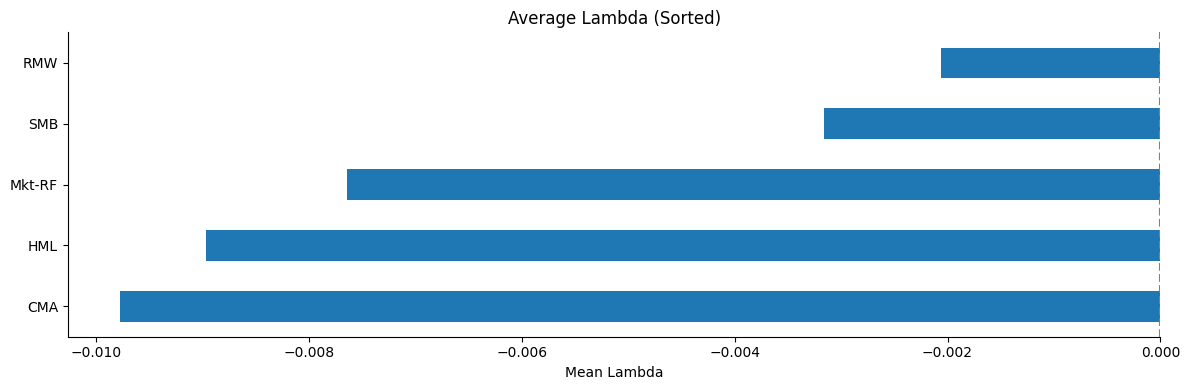

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 주어진 요약 데이터 만들기
summary = pd.DataFrame({
    'mean': {
        'Mkt-RF': -0.007646,
        'SMB': -0.003159,
        'HML': -0.008968,
        'RMW': -0.002061,
        'CMA': -0.009779
    },
    'std': {
        'Mkt-RF': 0.057844,
        'SMB': 0.036886,
        'HML': 0.043433,
        'RMW': 0.042661,
        'CMA': 0.040351
    },
    't': {
        'Mkt-RF': -1.315150,
        'SMB': -0.852170,
        'HML': -2.054451,
        'RMW': -0.480669,
        'CMA': -2.411457
    },
    'N(months)': {
        'Mkt-RF': 99,
        'SMB': 99,
        'HML': 99,
        'RMW': 99,
        'CMA': 99
    }
})

# 정렬된 평균 람다값 막대그래프
summary['mean'].sort_values().plot.barh(figsize=(12, 4))
plt.axvline(0, linestyle='--', color='gray')
plt.title("Average Lambda (Sorted)")
plt.xlabel("Mean Lambda")
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from linearmodels.asset_pricing import LinearFactorModel

# 1. 데이터 불러오기
portfolio_path = 'sector_weighted_excess_return_v2.csv'
factor_path = 'ff5factor_v2.csv'

# 포트폴리오 수익률 (업종별 시가총액 가중 초과수익률)
ff_portfolio_data = pd.read_csv(portfolio_path, index_col=0, encoding='cp949')
ff_portfolio_data.index = pd.to_datetime(ff_portfolio_data.index).to_period('M')

# 팩터 수익률 (Fama-French 5 Factor: Mkt-RF, SMB, HML, RMW, CMA)
ff_factor_data = pd.read_csv(factor_path, index_col=0, encoding='cp949')
ff_factor_data.index = pd.to_datetime(ff_factor_data.index).to_period('M')

# 2. 공통 기간 필터링
common_index = ff_portfolio_data.index.intersection(ff_factor_data.index)
ff_portfolio_data = ff_portfolio_data.loc[common_index]
ff_factor_data = ff_factor_data.loc[common_index]


# 4. Fama-MacBeth 회귀 실행
mod = LinearFactorModel(portfolios=ff_portfolio_data,
                        factors=ff_factor_data)

res = mod.fit(cov_type='robust')  # 이분산성 robust 옵션

# 5. 결과 출력
print(res)

*날짜 형식 바꾸는 코드 

In [36]:
import pandas as pd

# 파일 불러오기
df_rf = pd.read_csv('무위험수익률_Cd수익률_ym.csv', encoding='cp949')

# 날짜를 월-년 포맷으로 강제 파싱 ('%b-%y')
def parse_month_year(x):
    # 17-Jan 등에서 2017-01로 변환
    try:
        return pd.to_datetime(x, format='%y-%b').strftime('%Y-%m')
    except:
        return None

df_rf['YYYY-MM'] = df_rf['날짜'].apply(parse_month_year)

# 결과 확인
print(df_rf[['날짜', 'YYYY-MM', 'CD수익률']].head(20))

        날짜 YYYY-MM   CD수익률
0   Jan-17    None  0.0150
1   Feb-17    None  0.0149
2   Mar-17    None  0.0148
3   Apr-17    None  0.0143
4   May-17    None  0.0139
5   Jun-17    None  0.0138
6   Jul-17    None  0.0139
7   Aug-17    None  0.0139
8   Sep-17    None  0.0138
9   Oct-17    None  0.0138
10  Nov-17    None  0.0145
11  Dec-17    None  0.0166
12  Jan-18    None  0.0166
13  Feb-18    None  0.0165
14  Mar-18    None  0.0165
15  Apr-18    None  0.0165
16  May-18    None  0.0165
17  Jun-18    None  0.0165
18  Jul-18    None  0.0165
19  Aug-18    None  0.0165


In [ ]:
*cd금리 데이터 사이트: https://www.kofiabond.or.kr/